<a href="https://colab.research.google.com/github/Vigodang/Predictive-Data-Analytics/blob/main/CAB_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
# === Colab setup (run first) ===
!pip -q install numpy pandas matplotlib seaborn scikit-learn

import os, warnings, numpy as np, pandas as pd
import seaborn as sns

# Mount Drive
from google.colab import drive
drive.mount('/content/drive')

# Paths
ROOT = "/content/drive/MyDrive/CAB_2"
DATA = f"{ROOT}/data"
FIGS = f"{ROOT}/figures"
os.makedirs(DATA, exist_ok=True)
os.makedirs(FIGS, exist_ok=True)

# Style & reproducibility
RNG = 42
sns.set(style="whitegrid", context="notebook")
warnings.filterwarnings("ignore")


Mounted at /content/drive


In [ ]:
### TASK 1 - SETUP

# ===== Setup (run once) =====
!pip -q install numpy pandas matplotlib seaborn scikit-learn

import os, numpy as np, pandas as pd
import matplotlib.pyplot as plt, seaborn as sns
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

sns.set(style="whitegrid", context="notebook")
RNG = 42  # fixed random_state
plt.rcParams["figure.dpi"] = 120


DATASET1_PATH = "/content/drive/MyDrive/CAB_2/Dataset1_AudioTrack.csv"

# === Collumns from dataset ===
ID_COLS   = ["ID", "Name"]
NUM_COLS  = ["Energy", "Loudness", "Speechiness", "Instrumentalness", "time_signature"]
CAT_COLS  = ["Type"]

# === Valid ranges ===
VALID_RANGES = {
    "Energy": (0, 1),
    "Speechiness": (0, 1),
    "Instrumentalness": (0, 1),
    "Loudness": (-60, 0),
    "time_signature": (0, 5),
}

os.makedirs("/content/figs", exist_ok=True)


In [ ]:
### TASK 1 - QUESTION 1

# --- Q1: Data quality & cleaning ---

na_markers = ["", "NA", "NaN", "null", "none", "?", "N/A"]
df_raw = pd.read_csv(DATASET1_PATH, na_values=na_markers, encoding="latin1")

# Normalise dtypes for numeric columns
for c in NUM_COLS:
    if c in df_raw.columns:
        df_raw[c] = pd.to_numeric(df_raw[c], errors="coerce")

# Report missing & dtype
dq_report = pd.DataFrame({
    "dtype": df_raw.dtypes.astype(str),
    "missing": df_raw.isna().sum(),
    "missing_rate": (df_raw.isna().mean()*100).round(2)
})

# Check out-of-range
oor_counts = {}
for c, (lo, hi) in VALID_RANGES.items():
    if c in df_raw.columns:
        mask = ~df_raw[c].between(lo, hi)
        oor_counts[c] = int(mask.sum())
oor = pd.Series(oor_counts, name="out_of_range")

dq_report = dq_report.join(oor, how="left").fillna(0)

# === Cleaning decisions:
df1 = df_raw.copy()

# 1) Drop records with insufficient core digital data (too short)
min_required = int(np.ceil(len(NUM_COLS)*0.6))
df1 = df1[df1[NUM_COLS].notna().sum(axis=1) >= min_required].copy()

# 2) Cut (clip) to valid domain instead of deleting (keep more data)
for c, (lo, hi) in VALID_RANGES.items():
    if c in df1.columns:
        df1[c] = df1[c].clip(lower=lo, upper=hi)

# 3) Fill in the remaining missing values ​​using column median (okay for K-means)
for c in NUM_COLS:
    if c in df1.columns:
        df1[c] = df1[c].fillna(df1[c].median())

# 4) Delete duplicates by ID/Name if any
if set(ID_COLS).issubset(df1.columns):
    df1 = df1.drop_duplicates(subset=ID_COLS)

print("Shape raw -> clean:", df_raw.shape, "->", df1.shape)
dq_report




Shape raw -> clean: (2980, 8) -> (2686, 8)


,dtype,missing,missing_rate,out_of_range
ID,object,0,0.00,0.0
Name,object,0,0.00,0.0
Energy,float64,1,0.03,2.0
Loudness,float64,1,0.03,2.0
Speechiness,float64,0,0.00,1.0
Instrumentalness,float64,1,0.03,2.0
Type,object,0,0.00,0.0
time_signature,int64,0,0.00,0.0


,min,max
Energy,0.000,1.000
Loudness,-39.967,0.000
Speechiness,0.000,0.956
Instrumentalness,0.000,1.000
time_signature,0.000,5.000


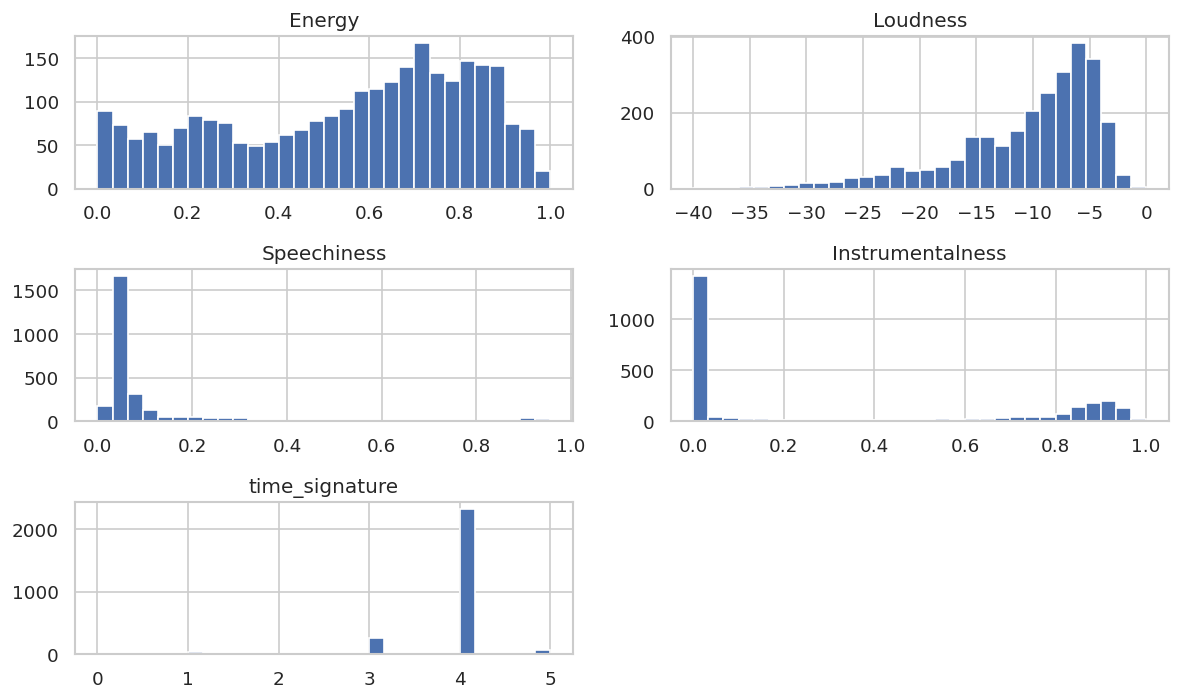

In [ ]:
### TASK 1 - QUESTION 2

# --- Q2: Feature selection & distributions ---
use_cols = [c for c in NUM_COLS if c in df1.columns]
X = df1[use_cols].copy()

# Table of min/max
minmax = pd.DataFrame({"min": X.min().round(3), "max": X.max().round(3)})
display(minmax)

# Distribution
_ = X.hist(bins=30, figsize=(10,6))
plt.tight_layout()
plt.savefig("/content/figs/T1_hist_features.png")
plt.savefig("/content/drive/MyDrive/CAB_2/figures/T1_hist_features.png")
plt.show()


Counts per cluster (k=3):


,count
Cluster_k3,
0,1700
1,696
2,290


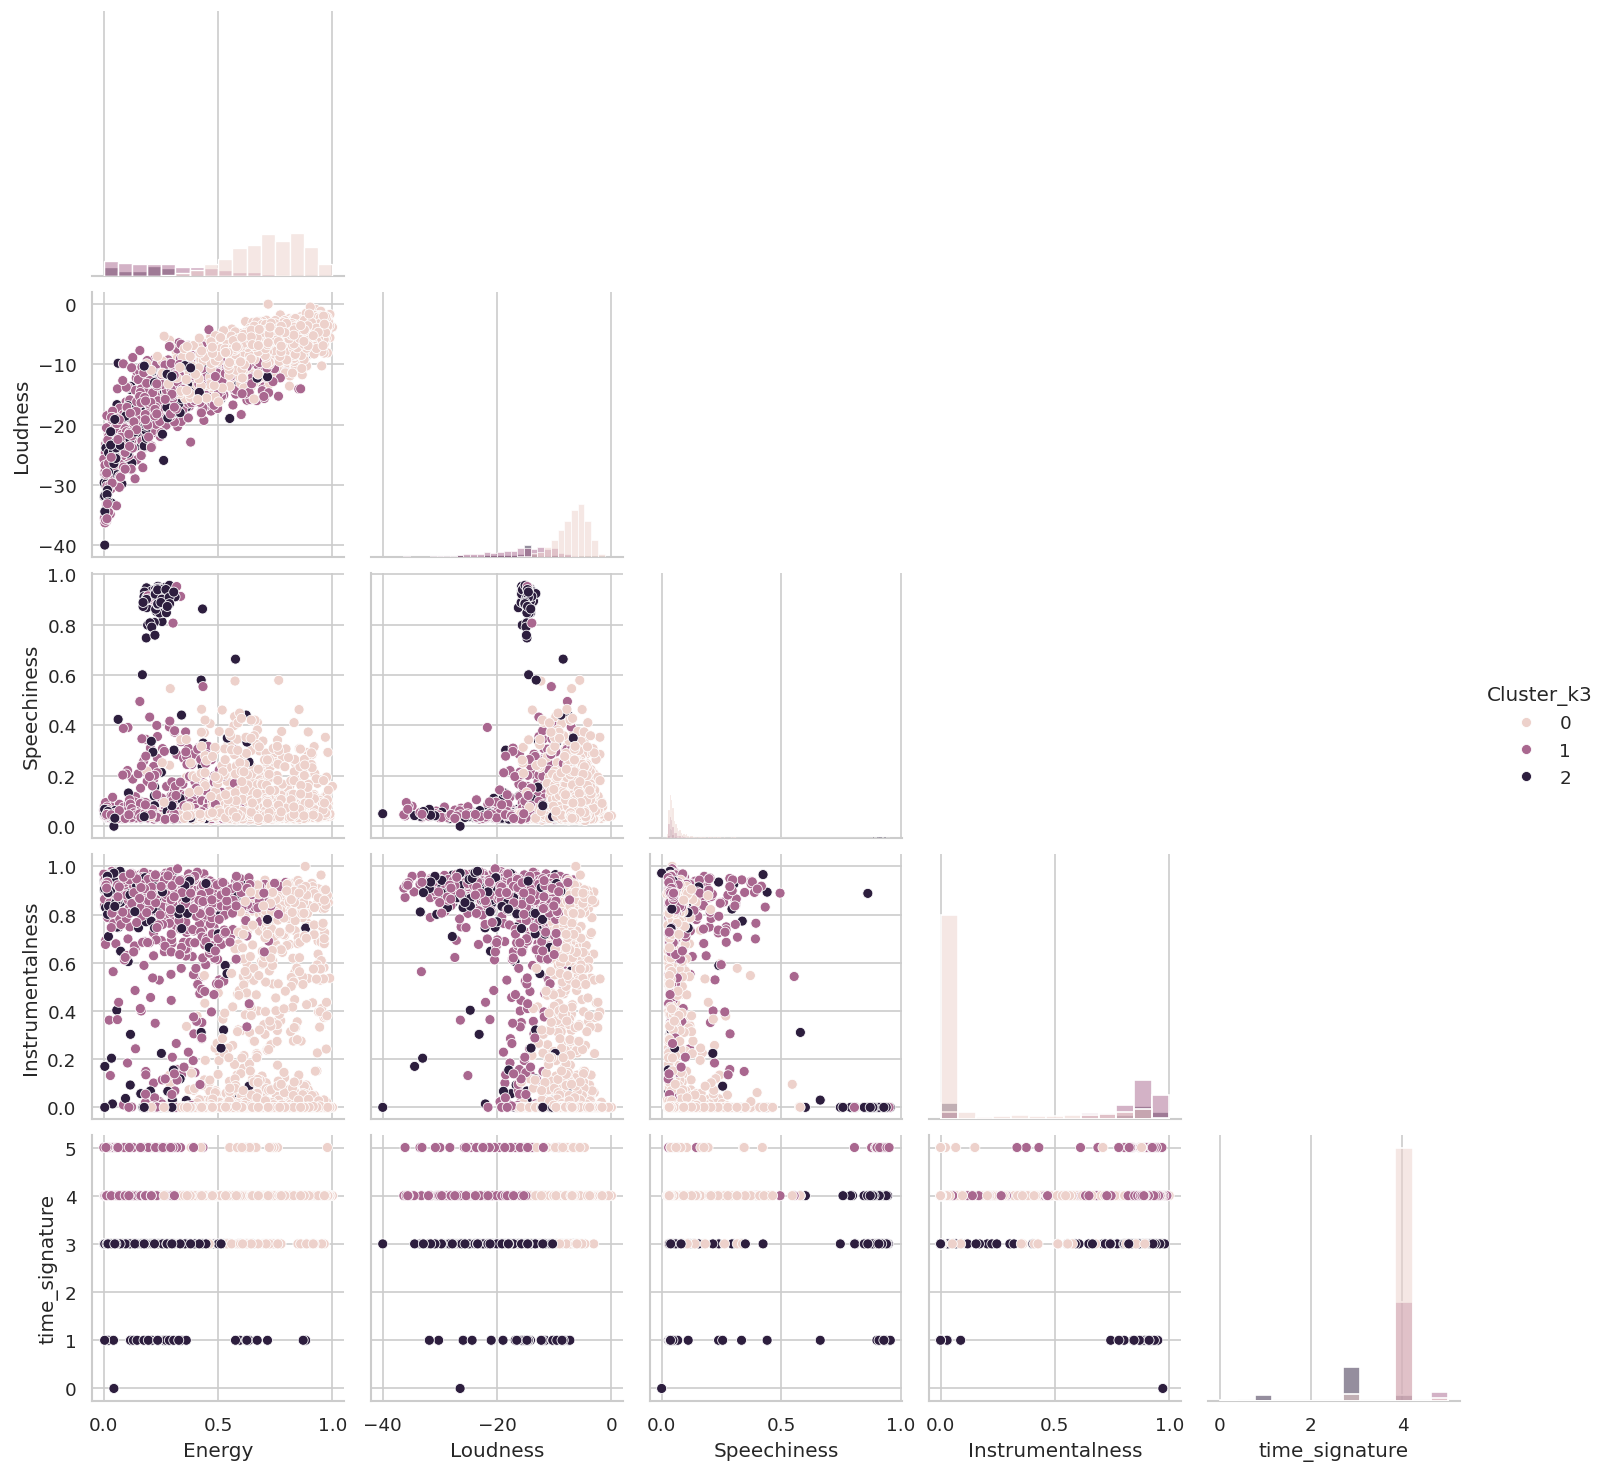

,Cluster0 (mean/[range]),Cluster1 (mean/[range]),Cluster2 (mean/[range])
Feature,,,
Energy,"0.719 / [0.188, 1.000]","0.286 / [0.000, 0.861]","0.220 / [0.002, 0.883]"
Loudness,"-6.753 / [-16.202, 0.000]","-16.403 / [-36.281, -4.237]","-17.804 / [-39.967, -6.526]"
Speechiness,"0.076 / [0.022, 0.579]","0.091 / [0.027, 0.951]","0.313 / [0.000, 0.956]"
Instrumentalness,"0.126 / [0.000, 1.000]","0.768 / [0.000, 0.990]","0.534 / [0.000, 0.980]"
time_signature,"3.986 / [3.000, 5.000]","4.079 / [4.000, 5.000]","2.886 / [0.000, 4.000]"


In [ ]:
### TASK 1 - QUESTION 3

# --- Q3: Default KMeans k=3 ---
sc_temp = StandardScaler()
Xz = sc_temp.fit_transform(X)

k3 = KMeans(n_clusters=3, random_state=RNG, n_init="auto").fit(Xz)
df1["Cluster_k3"] = k3.labels_

# (a) number of points in each cluster
counts_k3 = df1["Cluster_k3"].value_counts().sort_index()
print("Counts per cluster (k=3):")
display(counts_k3)

# (b) Pairplot + mean table & range follow by cluster
import seaborn as sns
sns.pairplot(df1[use_cols + ["Cluster_k3"]], hue="Cluster_k3", corner=True, diag_kind="hist")
plt.savefig("/content/figs/T1_pairplot_k3.png")
plt.savefig("/content/drive/MyDrive/CAB_2/figures/T1_pairplot_k3.png")
plt.show()

summary_k3 = (df1.groupby("Cluster_k3")[use_cols]
                .agg(['mean', 'min', 'max']).round(3))
summary_k3


# Converting summary table to "mean / [min, max]" format

features = summary_k3.columns.get_level_values(0).unique().tolist()
formatted = pd.DataFrame(index = features)

for c in summary_k3.index:
  col = []
  for f in features:
    mean = summary_k3.loc[c, (f, 'mean')]
    min = summary_k3.loc[c, (f, 'min')]
    max = summary_k3.loc[c, (f, 'max')]
    col.append(f"{mean:.3f} / [{min:.3f}, {max:.3f}]")
  formatted[f"Cluster{c} (mean/[range])"] = col

formatted.index.name = "Feature"
if 'use_cols' in locals():
  formatted = formatted.reindex(use_cols)
formatted



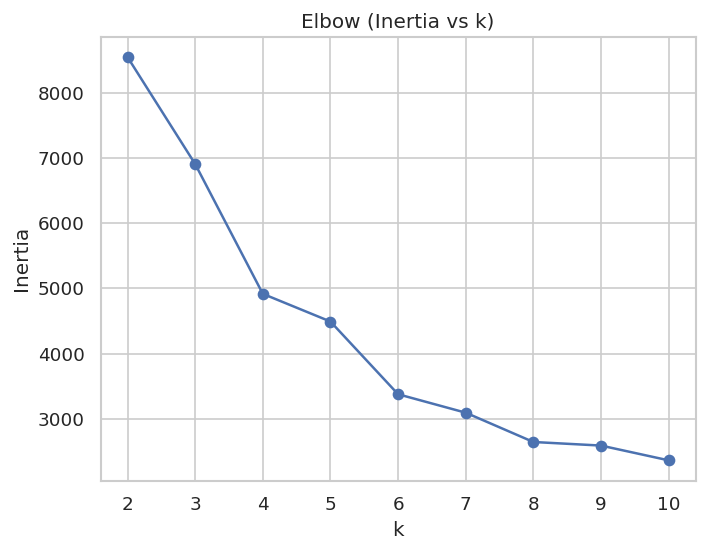

<Figure size 768x576 with 0 Axes>

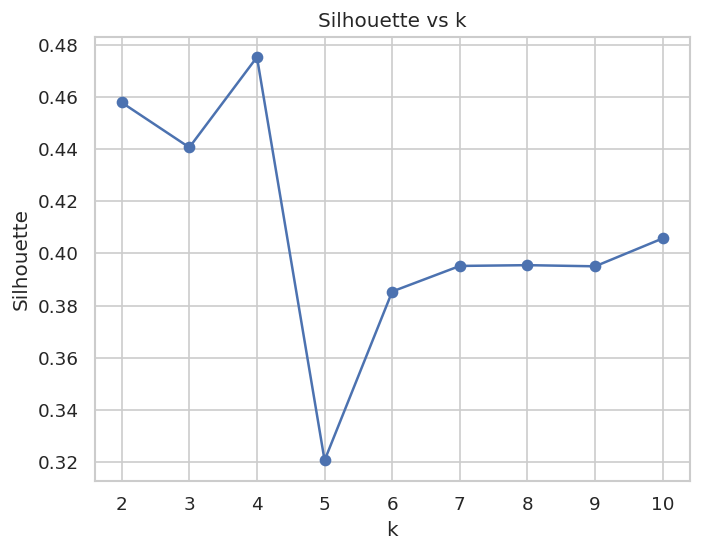

Chosen k* (by silhouette) = 4 ; silhouette = 0.47529992686253525


<Figure size 768x576 with 0 Axes>

In [ ]:
### TASK 1 - QUESTION 4

# --- Q4: Optimal k (Elbow + Silhouette) ---
Ks = range(2, 11)
inertia, sil = [], []

for kk in Ks:
    km = KMeans(n_clusters=kk, random_state=RNG, n_init="auto").fit(Xz)
    inertia.append(km.inertia_)
    sil.append(silhouette_score(Xz, km.labels_))

plt.figure(); plt.plot(Ks, inertia, marker="o"); plt.title("Elbow (Inertia vs k)")
plt.xlabel("k"); plt.ylabel("Inertia"); plt.grid(True)
plt.savefig("/content/figs/T1_elbow.png"); plt.show()
plt.savefig("/content/drive/MyDrive/CAB_2/figures/T1.elbow.png")

plt.figure(); plt.plot(Ks, sil, marker="o"); plt.title("Silhouette vs k")
plt.xlabel("k"); plt.ylabel("Silhouette"); plt.grid(True)
plt.savefig("/content/figs/T1_silhouette.png"); plt.show()
plt.savefig("/content/drive/MyDrive/CAB_2/figures/T1_silhouette.png")

k_star = Ks[int(np.argmax(sil))]
print("Chosen k* (by silhouette) =", k_star, "; silhouette =", np.max(sil))


In [ ]:
### TASK 1 - QUESTION 5

# --- Q5: Scaling comparison at k* ---
def fit_with_scaler(scaler, X, k):
    sc = scaler()
    Xs = sc.fit_transform(X)
    km = KMeans(n_clusters=k, random_state=RNG, n_init="auto").fit(Xs)
    return sc, km, silhouette_score(Xs, km.labels_), Xs

sc_std, km_std, sil_std, X_std = fit_with_scaler(StandardScaler, X, k_star)
sc_mm,  km_mm,  sil_mm,  X_mm  = fit_with_scaler(MinMaxScaler,  X, k_star)

print(f"Silhouette: Standard={sil_std:.3f} | MinMax={sil_mm:.3f}")
better = "std" if sil_std >= sil_mm else "mm"
sc_best, km_best, X_best = (sc_std, km_std, X_std) if better=="std" else (sc_mm, km_mm, X_mm)
df1[f"Cluster_k{k_star}_{better}"] = km_best.labels_
print("Better scaler =", "StandardScaler" if better=="std" else "MinMaxScaler")


Silhouette: Standard=0.475 | MinMax=0.570
Better scaler = MinMaxScaler


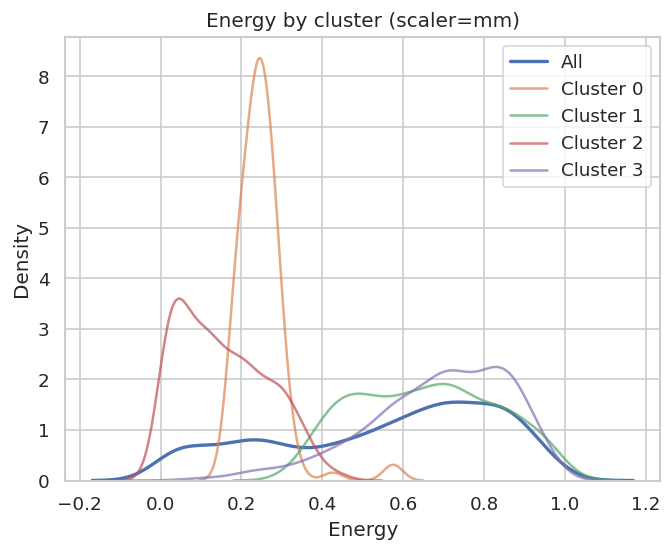

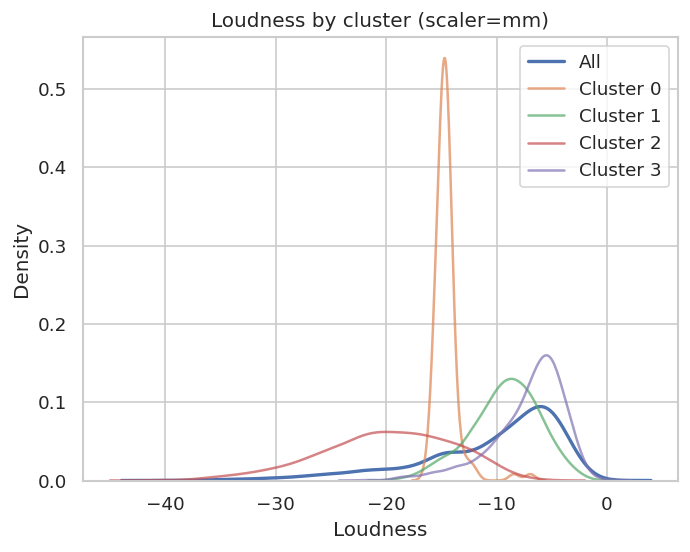

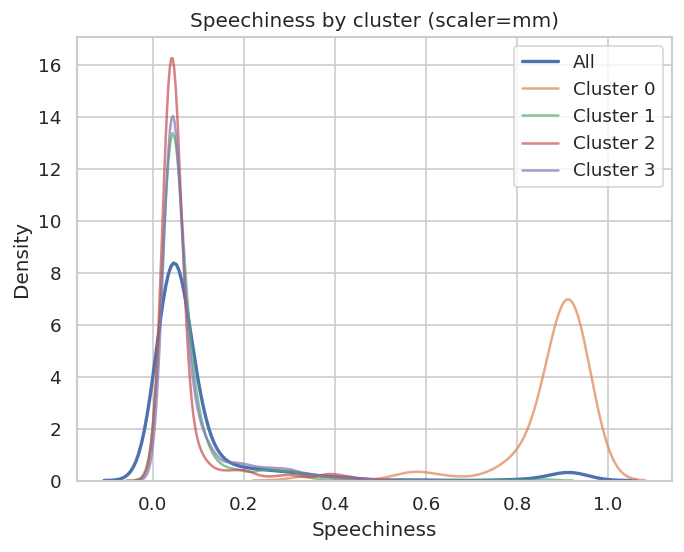

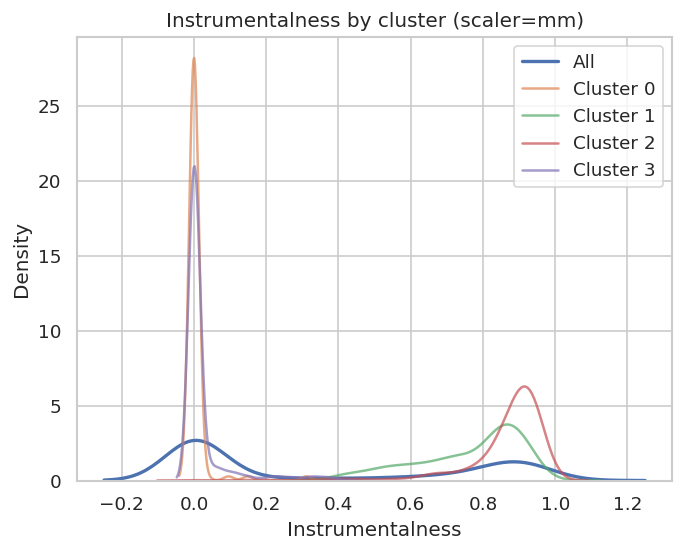

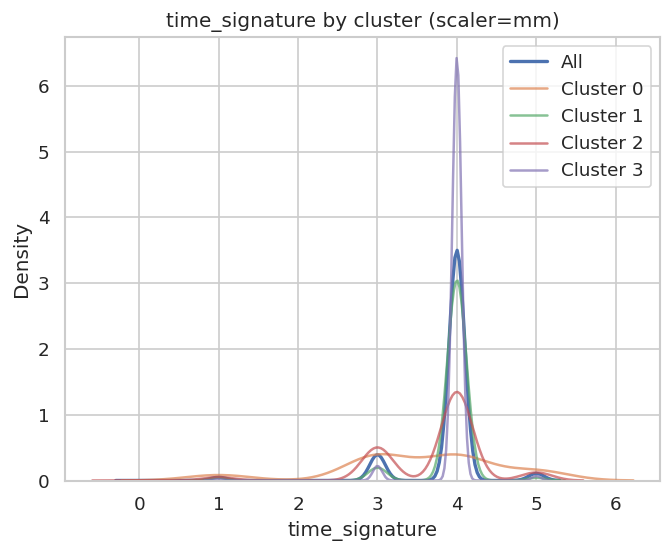

In [ ]:
### TASK 1 - QUESTION 6

# --- Q6: Distributions by cluster for the better scaler ---
cid = f"Cluster_k{k_star}_{better}"

for col in use_cols:
    plt.figure()
    # overall
    sns.kdeplot(df1[col], linewidth=2, label="All")
    # each cluster
    for c in sorted(df1[cid].unique()):
        sns.kdeplot(df1.loc[df1[cid]==c, col], alpha=.7, label=f"Cluster {c}")
    plt.title(f"{col} by cluster (scaler={better})")
    plt.legend()
    plt.savefig(f"/content/figs/T1_{col}_by_cluster_{better}.png")
    plt.show()


In [ ]:
### TASK 1 - QUESTION 7

# --- Q7: Plain cluster profiles ---
cid = f"Cluster_k{k_star}_{better}"
global_mean = df1[use_cols].mean()

# The final of table of mean/min/max
final_profile = (df1.groupby(cid)[use_cols]
                   .agg(['mean','min','max']).round(3))
# display(final_profile)

# Converting summary table to "mean / [min, max]" format

features_7 = final_profile.columns.get_level_values(0).unique().tolist()
formatted_7 = pd.DataFrame(index = features_7)

for c in final_profile.index:
  col = []
  for f in features_7:
    mean = final_profile.loc[c, (f, 'mean')]
    min = final_profile.loc[c, (f, 'min')]
    max = final_profile.loc[c, (f, 'max')]
    col.append(f"{mean:.3f} / [{min:.3f}, {max:.3f}]")
  formatted_7[f"Cluster{c} (mean/[range])"] = col

formatted_7.index.name = "Feature"
if 'use_cols' in locals():
  formatted_7 = formatted_7.reindex(use_cols)
display(formatted_7)


def describe_cluster(means, global_mean, feat):
    diff = means[feat] - global_mean[feat]
    # Qualitative threshold (1/4 global standard deviation)
    thr = df1[feat].std() * 0.25
    if diff >  thr: txt = "high"
    elif diff < -thr: txt = "low"
    else: txt = "medium"
    return txt

for c, grp in df1.groupby(cid):
    means = grp[use_cols].mean()
    tags = {f: describe_cluster(means, global_mean, f) for f in use_cols}
    print(f"Cluster {c}: " + ", ".join([f"{f}={v}" for f,v in tags.items()]))






,Cluster0 (mean/[range]),Cluster1 (mean/[range]),Cluster2 (mean/[range]),Cluster3 (mean/[range])
Feature,,,,
Energy,"0.249 / [0.169, 0.576]","0.656 / [0.328, 0.988]","0.155 / [0.000, 0.455]","0.688 / [0.038, 1.000]"
Loudness,"-14.541 / [-16.268, -6.950]","-9.221 / [-18.961, -1.977]","-19.864 / [-39.967, -7.027]","-7.067 / [-22.028, 0.000]"
Speechiness,"0.876 / [0.345, 0.956]","0.070 / [0.022, 0.862]","0.064 / [0.000, 0.495]","0.079 / [0.024, 0.579]"
Instrumentalness,"0.006 / [0.000, 0.311]","0.765 / [0.391, 1.000]","0.865 / [0.000, 0.990]","0.024 / [0.000, 0.397]"
time_signature,"3.509 / [1.000, 5.000]","3.917 / [1.000, 5.000]","3.730 / [0.000, 5.000]","3.969 / [1.000, 5.000]"


Cluster 0: Energy=low, Loudness=low, Speechiness=high, Instrumentalness=low, time_signature=low
Cluster 1: Energy=high, Loudness=medium, Speechiness=medium, Instrumentalness=high, time_signature=medium
Cluster 2: Energy=low, Loudness=low, Speechiness=medium, Instrumentalness=high, time_signature=low
Cluster 3: Energy=high, Loudness=high, Speechiness=medium, Instrumentalness=low, time_signature=medium


In [ ]:
features_7

['Energy', 'Loudness', 'Speechiness', 'Instrumentalness', 'time_signature']

In [ ]:
### TASK 2 - SETUP

# Install & imports
!pip -q install pandas numpy matplotlib seaborn mlxtend

import warnings
import os, re, numpy as np, pandas as pd
import matplotlib.pyplot as plt, seaborn as sns
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import apriori, association_rules

# To ignore any future warnings
warnings.filterwarnings("ignore")

sns.set(style="whitegrid", context="notebook")
plt.rcParams["figure.dpi"] = 140

# === PATH ===
DATASET2_PATH = "/content/drive/MyDrive/CAB_2/Dataset2_TRANS.csv"

df = pd.read_csv(DATASET2_PATH)



In [ ]:
### TASK 2 - QUESTION 2

# Variables used: TRANSACTION_ID (group key), PRODUCT_NAME (item)
# Build basket: list-of-lists (transactions) & one-hot DF
tx_items = (df.groupby("Transaction_Id")["Product_Name"]
              .apply(lambda s: sorted(set(s)))      # unique items per txn
              .tolist())

# Optional: remove 1-item baskets (they don't produce rules length>=2)
tx_items = [b for b in tx_items if len(b) >= 2]
n_txn_eff = len(tx_items)
print("Transactions used:", n_txn_eff)

# One-hot using TransactionEncoder (for mlxtend.apriori)
te = TransactionEncoder()
ohe = te.fit(tx_items).transform(tx_items)
basket_df = pd.DataFrame(ohe, columns=te.columns_).astype("uint8")
basket_df.shape


Transactions used: 56401


(56401, 17)

In [ ]:
### TASK 2 - QUESTION 3
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

MIN_SUP = 0.015
MIN_CONF = 0.12

# Frequent itemsets
freq = apriori(basket_df, min_support=MIN_SUP, use_colnames = True)
freq["itemset_len"] = freq["itemsets"].apply(len)

# Association rules (filter by confidence)
rules = association_rules(freq, metric="confidence", min_threshold = MIN_CONF)

# Tidy up columns
rules["antecedents"] = rules["antecedents"].apply(lambda s: tuple(sorted(list(s))))
rules["consequents"] = rules["consequents"].apply(lambda s: tuple(sorted(list(s))))
rules["antecedent_len"] = rules["antecedents"].str.len()
rules["consequent_len"] = rules["consequents"].str.len()

# Add expected_confidence = support(B)
conseq_support = (freq.set_index("itemsets")["support"])
rules["expected_confidence"] = rules["consequents"].apply(
    lambda c: conseq_support.get(frozenset(c), np.nan)
)

# Nice ordering
cols = ["antecedents","consequents","support","confidence", "lift"] # Excluded "expected_confidence","lift","leverage","conviction","antecedent_len","consequent_len"
rules = rules[cols].sort_values(["lift","confidence","support"], ascending=False).reset_index(drop=True)
print("Rules found:", len(rules))
rules


Rules found: 130


,antecedents,consequents,support,confidence,lift
0,"(Sugar,)","(Cheese,)",0.021542,0.295620,9.779055
1,"(Cheese,)","(Sugar,)",0.021542,0.712610,9.779055
2,"(Bread,)","(Butter,)",0.040212,0.531023,3.430726
3,"(Butter,)","(Bread,)",0.040212,0.259794,3.430726
4,"(Milk,)","(Butter,)",0.029343,0.517349,3.342384
5,"(Butter,)","(Milk,)",0.029343,0.189576,3.342384
6,"(Conditioner,)","(Butter,)",0.077375,0.514441,3.323593
7,"(Butter,)","(Conditioner,)",0.077375,0.499885,3.323593
8,"(Butter, Tea)","(Conditioner,)",0.023014,0.492600,3.275152
9,"(Conditioner,)","(Butter, Tea)",0.023014,0.153012,3.275152


In [ ]:
### TASK 2 - QUESTION 4

# Highest confidence rule
top_conf = rules.sort_values(["confidence","lift","support"], ascending=False).head(1)

# Highest lift rule
top_lift = rules.sort_values(["lift","confidence","support"], ascending=False).head(1)

print("== Highest Confidence ==")
display(top_conf)
print("== Highest Lift ==")
display(top_lift)



== Highest Confidence ==


,antecedents,consequents,support,confidence,lift
1,"(Cheese,)","(Sugar,)",0.021542,0.71261,9.779055


== Highest Lift ==


,antecedents,consequents,support,confidence,lift
0,"(Sugar,)","(Cheese,)",0.021542,0.29562,9.779055


Rules with lift ≥ 1.4: 18


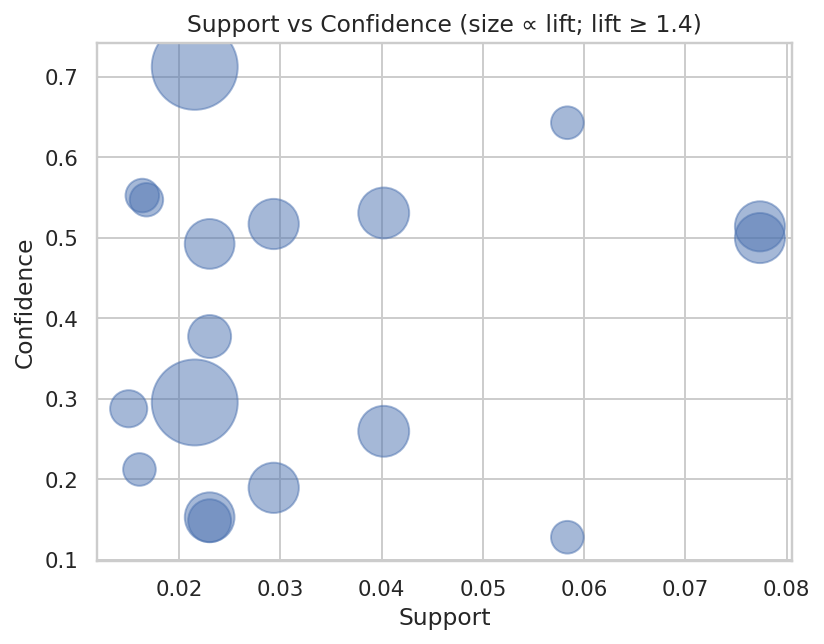

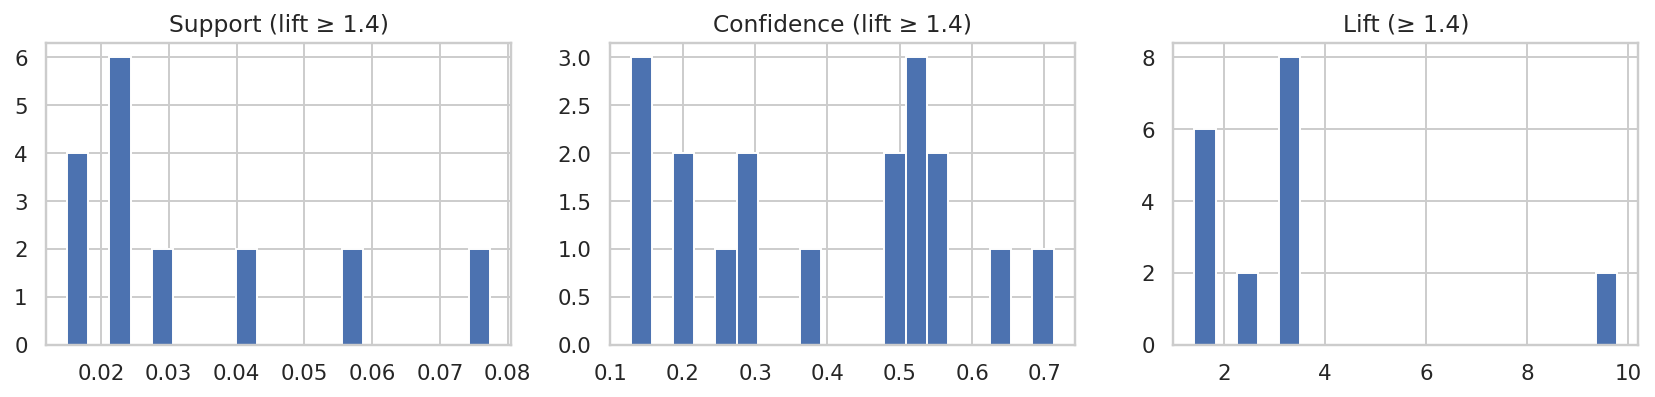

In [ ]:
### TASK 2 - QUESTION 5

rules_plot = rules[rules["lift"] >= 1.4].copy()
print("Rules with lift ≥ 1.4:", len(rules_plot))

plt.figure()
plt.scatter(rules_plot["support"], rules_plot["confidence"], s=200*rules_plot["lift"], alpha=0.5)
plt.xlabel("Support")
plt.ylabel("Confidence")
plt.title("Support vs Confidence (size ∝ lift; lift ≥ 1.4)")
plt.grid(True)
plt.show()

# (Optional) histograms
fig, axs = plt.subplots(1,3, figsize=(12,3))
axs[0].hist(rules_plot["support"], bins=20); axs[0].set_title("Support (lift ≥ 1.4)")
axs[1].hist(rules_plot["confidence"], bins=20); axs[1].set_title("Confidence (lift ≥ 1.4)")
axs[2].hist(rules_plot["lift"], bins=20); axs[2].set_title("Lift (≥ 1.4)")
for ax in axs: ax.grid(True)
plt.tight_layout(); plt.show()


In [ ]:
### TASK 2 - QUESTION 6

target = "Shampoo"

def contains_item(tup, item):
    return any(str(x)==item for x in tup)

shampoo_rules = rules[rules.apply(
    lambda r: contains_item(r["antecedents"], target) or contains_item(r["consequents"], target), axis=1
)].sort_values(["lift","confidence","support"], ascending=False)

print("Shampoo-related rules:", len(shampoo_rules))
shampoo_rules


Shampoo-related rules: 59


,antecedents,consequents,support,confidence,lift
14,"(Cordial, Shampoo, Tea)","(Yoghurt,)",0.016773,0.547454,1.478568
18,"(Cordial, Shampoo)","(Tea, Yoghurt)",0.016773,0.192590,1.339860
19,"(Egg, Shampoo, Tea)","(Yoghurt,)",0.020638,0.487233,1.315924
20,"(Shampoo, Tea, Yoghurt)","(Egg,)",0.020638,0.424198,1.309392
23,"(Shampoo, Tea)","(Cordial, Yoghurt)",0.016773,0.149376,1.275931
24,"(Cordial, Yoghurt)","(Shampoo, Tea)",0.016773,0.143268,1.275931
25,"(Cordial, Tea, Yoghurt)","(Shampoo,)",0.016773,0.394002,1.273256
26,"(Shampoo, Tea, Yoghurt)","(Cordial,)",0.016773,0.344752,1.269629
29,"(Egg, Shampoo)","(Tea, Yoghurt)",0.020638,0.181421,1.262162
30,"(Tea, Yoghurt)","(Egg, Shampoo)",0.020638,0.143580,1.262162


In [ ]:
### TASK 2 - QUESTION 7

# Helper to format a rule row nicely
def fmt_rule(row):
    A = ", ".join(row["antecedents"])
    B = ", ".join(row["consequents"])
    return f"{{{A}}} → {{{B}}} | support={row['support']:.3f}, conf={row['confidence']:.3f}, lift={row['lift']:.2f}"

# 1) Cross-sell / combo pricing
r1 = shampoo_rules.head(1).iloc[0] if len(shampoo_rules)>0 else rules.head(1).iloc[0]
print("Cross-sell candidate:", fmt_rule(r1))

# 2) In-aisle placement / planogram
r2 = rules.sort_values("lift", ascending=False).iloc[0]
print("Co-location candidate:", fmt_rule(r2))


Cross-sell candidate: {Cordial, Shampoo, Tea} → {Yoghurt} | support=0.017, conf=0.547, lift=1.48
Co-location candidate: {Sugar} → {Cheese} | support=0.022, conf=0.296, lift=9.78


In [ ]:
### TASK 3 - SETUP

# === Install & imports
!pip -q install pandas numpy matplotlib seaborn scikit-learn nltk

import os, re, numpy as np, pandas as pd
import matplotlib.pyplot as plt, seaborn as sns
from collections import Counter, defaultdict
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.cluster import KMeans

import nltk, warnings
nltk.download('stopwords'); nltk.download('wordnet'); nltk.download('omw-1.4')
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

sns.set(style="whitegrid", context="notebook")
plt.rcParams["figure.dpi"] = 140
warnings.filterwarnings("ignore")

# === Path to dataset (EDIT THIS)
DATASET3_PATH = "/content/drive/MyDrive/CAB_2/Dataset3_Movie.csv"

# Robust read (encoding fallbacks)
for enc in ["utf-8","utf-8-sig","cp1252","latin1","ISO-8859-1"]:
    try:
        df = pd.read_csv(DATASET3_PATH, encoding=enc)
        print("Loaded with", enc, df.shape); break
    except Exception as e:
        pass

# Normalise headers
df.columns = df.columns.str.strip().str.title()
print("Columns after normalization:", df.columns.tolist())
assert "Description" in df.columns and "Genre" in df.columns, "Missing Description/Genre columns"

# Keep only the fields we need for this task
base_cols = ["Title","Genre","Description"]
for c in base_cols:
    if c not in df.columns: df[c] = np.nan
df = df[base_cols].copy()
df.reset_index(drop=True, inplace=True)
print(df.shape)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


Loaded with utf-8 (799, 21)
Columns after normalization: ['Cast 1', 'Cast 2', 'Cast 3', 'Cast 4', 'Cast 5', 'Cast 6', 'Description', 'Director 1', 'Director 2', 'Director 3', 'Genre', 'Rating', 'Release Date', 'Runtime', 'Studio', 'Title', 'Writer 1', 'Writer 2', 'Writer 3', 'Writer 4', 'Year']
(799, 3)


[nltk_data]   Package omw-1.4 is already up-to-date!


In [ ]:
### TASK 3 - QUESTION 1

# Description value at row index 23
desc_24 = df.loc[23, "Description"]
print("Description (index=23):\n", desc_24, "\n")

# Average length (in words) of Description
def count_words(txt):
    return 0 if pd.isna(txt) else len(re.findall(r"\b\w+\b", str(txt)))
avg_len = df["Description"].apply(count_words).mean()
print(f"Average Description length = {avg_len:.2f} words")

# Count rows per Genre
genre_counts = df["Genre"].fillna("Unknown").value_counts().rename_axis("Genre").to_frame("Rows")
display(genre_counts)


Description (index=23):
 Werner Herzog confirms his standing as poet laureate of men in extreme situations with "Encounters at the End of the World." In this visually stunning exploration, Herzog travels to the Antarctic community of McMurdo Station, headquarters of the National Science Foundation and home to 1,100 people during the austral summer (Oct-Feb). Over the course of his journey, Herzog examines human nature and Mother nature, juxtaposing breathtaking locations with the profound, surreal, and sometimes absurd experiences of the marine biologists, physicists, plumbers, and truck drivers who choose to form a society as far away from society as one can get. 

Average Description length = 128.77 words


,Rows
Genre,
Documentary,200
SciFi,200
Romance,200
Kids&Family,199


In [ ]:
### TASK 3 - QUESTION 2

STOP = set(stopwords.words("english"))
LEM  = WordNetLemmatizer()

def preprocess(text:str) -> list[str]:
    if not isinstance(text, str): return []
    t = text.lower()
    t = re.sub(r"[^a-z\s]", " ", t)              # remove punctuation/digits
    toks = [w for w in t.split() if len(w) >= 3] # short-token filter (handout hint)
    toks = [w for w in toks if w not in STOP]    # remove stopwords
    toks = [LEM.lemmatize(w) for w in toks]      # lemmatize
    return toks

df["Parsed_description"] = df["Description"].apply(preprocess)
print("Parsed tokens (index=23):\n", df.loc[23, "Parsed_description"][:50])  # preview
# (keep as list for later, but also store a joined string for sklearn vectorizers)
df["Parsed_str"] = df["Parsed_description"].apply(lambda toks: " ".join(toks))


Parsed tokens (index=23):
 ['werner', 'herzog', 'confirms', 'standing', 'poet', 'laureate', 'men', 'extreme', 'situation', 'encounter', 'end', 'world', 'visually', 'stunning', 'exploration', 'herzog', 'travel', 'antarctic', 'community', 'mcmurdo', 'station', 'headquarters', 'national', 'science', 'foundation', 'home', 'people', 'austral', 'summer', 'oct', 'feb', 'course', 'journey', 'herzog', 'examines', 'human', 'nature', 'mother', 'nature', 'juxtaposing', 'breathtaking', 'location', 'profound', 'surreal', 'sometimes', 'absurd', 'experience', 'marine', 'biologist', 'physicist']


,term,idx,tf,df
0,film,4385,405,261
1,life,6904,361,254
2,one,8318,285,202
3,new,8080,233,180
4,year,13123,224,176
5,world,13059,208,166
6,story,11349,199,164
7,family,4226,197,142
8,love,7080,194,146
9,find,4406,190,158


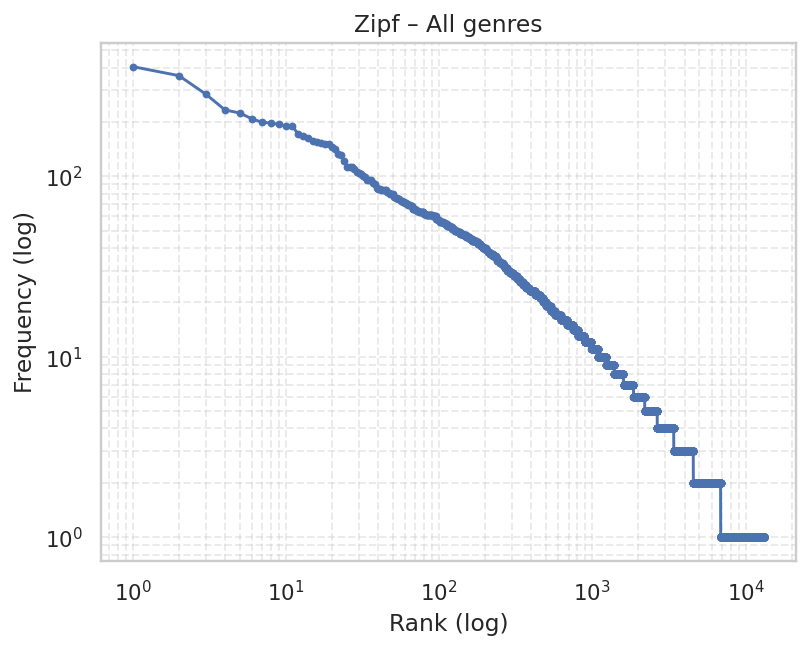

In [ ]:
### TASK 3 - QUESTION 3


# Count vectorizer on preprocessed strings
cv = CountVectorizer(lowercase=False, tokenizer=str.split, preprocessor=None)  # we already preprocessed
Xc = cv.fit_transform(df["Parsed_str"])

vocab = np.array(cv.get_feature_names_out())
tf = np.asarray(Xc.sum(axis=0)).ravel()
dfreq = np.asarray((Xc > 0).sum(axis=0)).ravel()
idx = np.arange(len(vocab))

terms = pd.DataFrame({
    "term": vocab, "idx": idx, "tf": tf, "df": dfreq
}).sort_values("tf", ascending=False).reset_index(drop=True)
display(terms.head(15))

# Plot Zipf: rank vs frequency (log-log)
def plot_zipf_from_counts(freq_array, title="Zipf plot"):
    counts = np.sort(freq_array)[::-1]
    ranks = np.arange(1, len(counts)+1)
    plt.figure()
    plt.loglog(ranks, counts, marker=".")
    plt.xlabel("Rank (log)"); plt.ylabel("Frequency (log)"); plt.title(title)
    plt.grid(True, which="both", ls="--", alpha=0.4)
    plt.show()

plot_zipf_from_counts(tf, "Zipf – All genres")


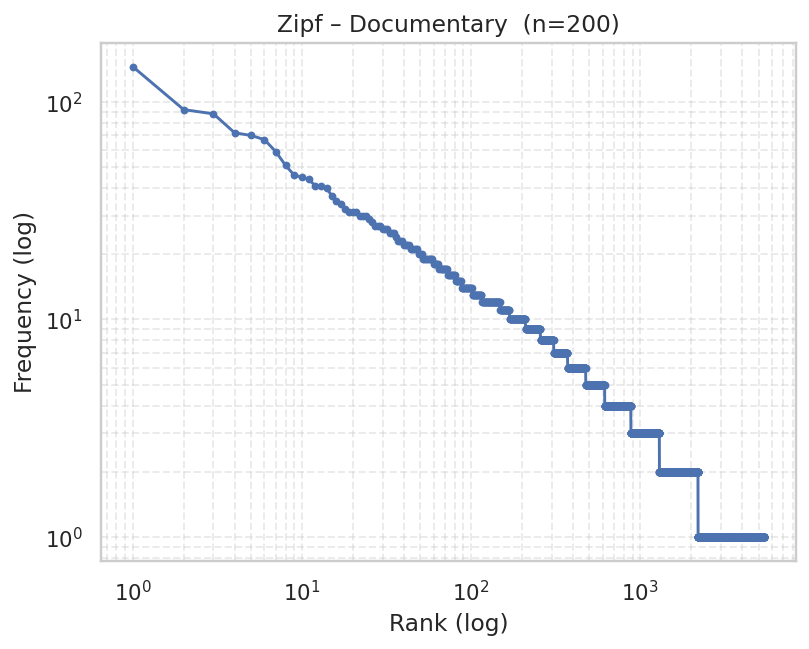

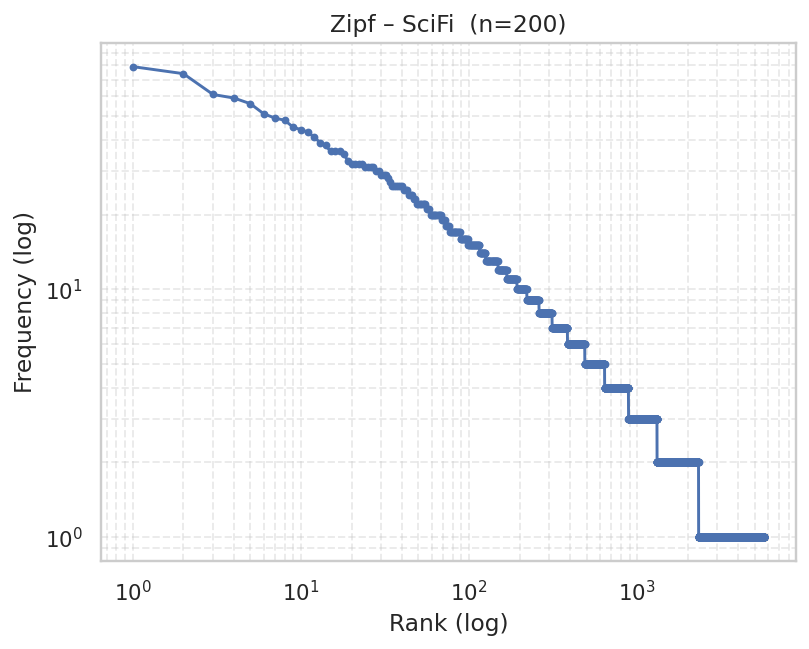

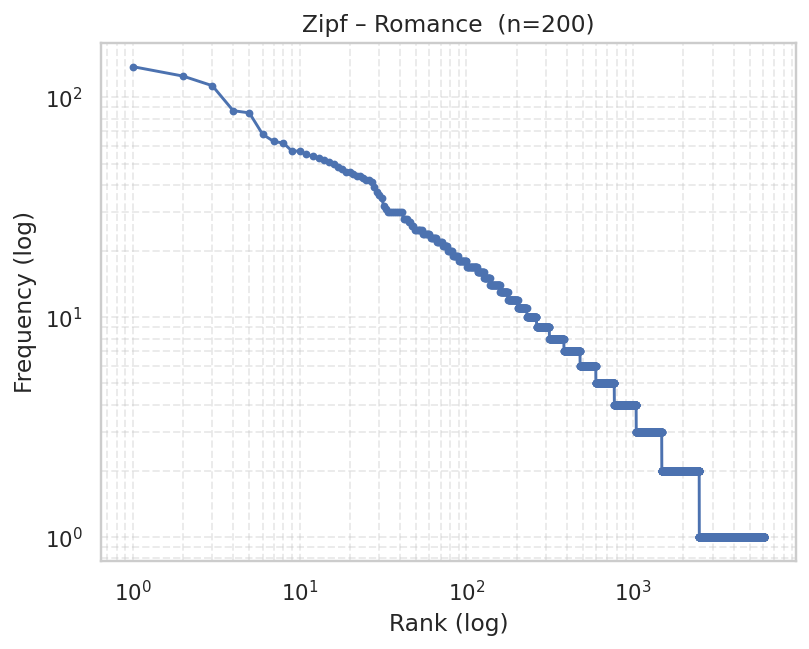

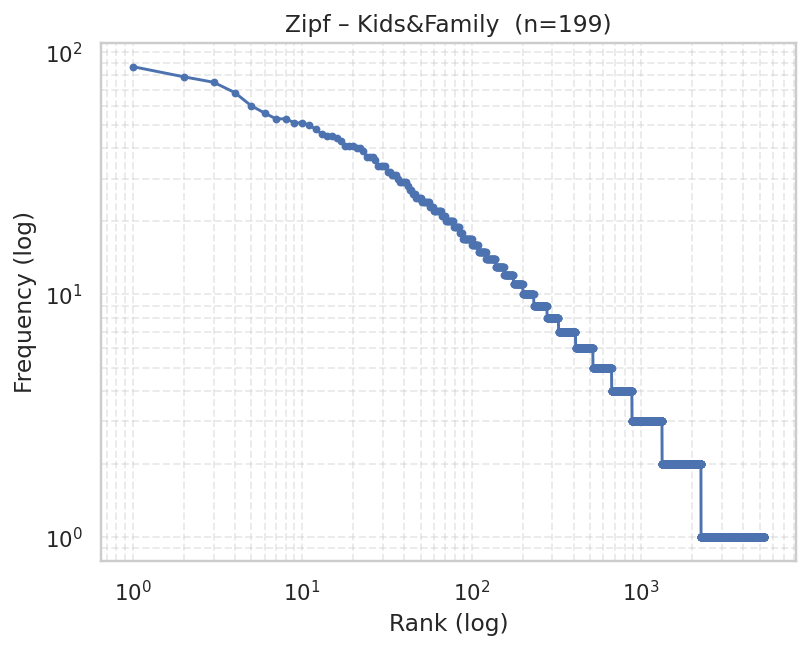

In [ ]:
### TASK 3 - QUESTION 4

genres_order = ["Documentary", "SciFi", "Romance", "Kids&Family"]
sub_data = []
for g in genres_order:
    sub = df[df["Genre"].str.contains(g, case=False, na=False)].copy()
    sub_data.append(sub)

# Zipf per genre
for g, sub in zip(genres_order, sub_data):
    cv_g = CountVectorizer(lowercase=False, tokenizer=str.split, preprocessor=None)
    Xg = cv_g.fit_transform(sub["Parsed_str"])
    tf_g = np.asarray(Xg.sum(axis=0)).ravel()
    plot_zipf_from_counts(tf_g, f"Zipf – {g}  (n={len(sub)})")




=== Documentary ===


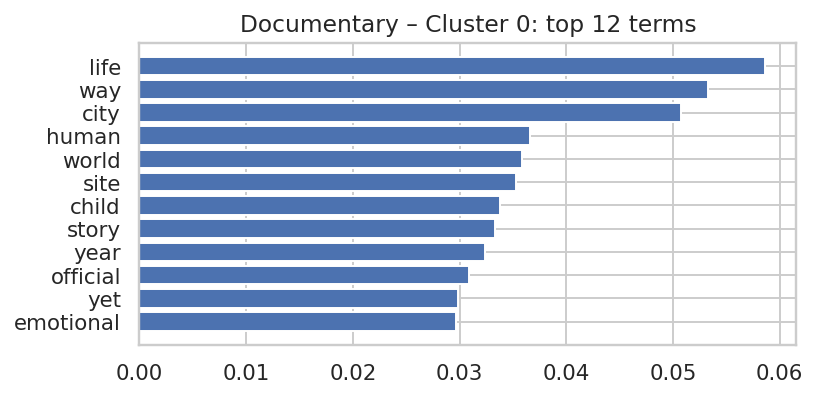

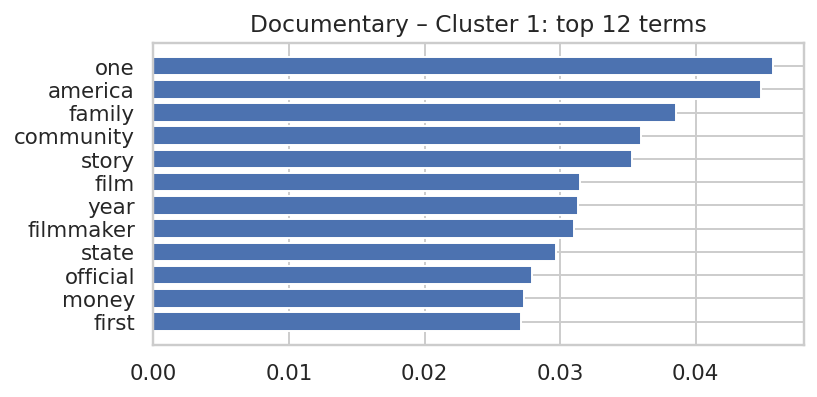

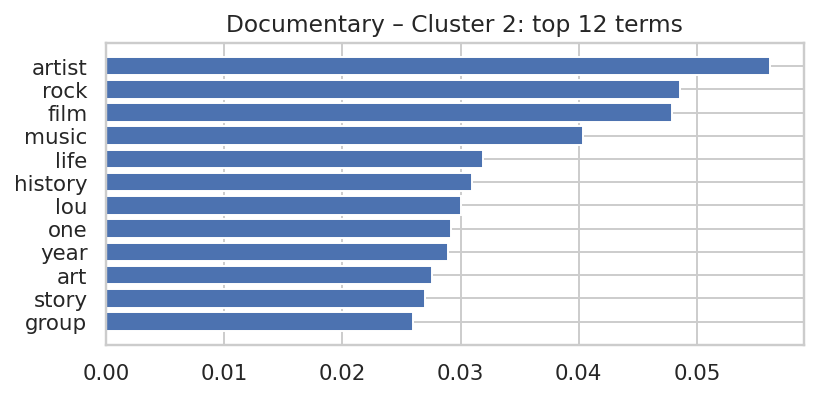

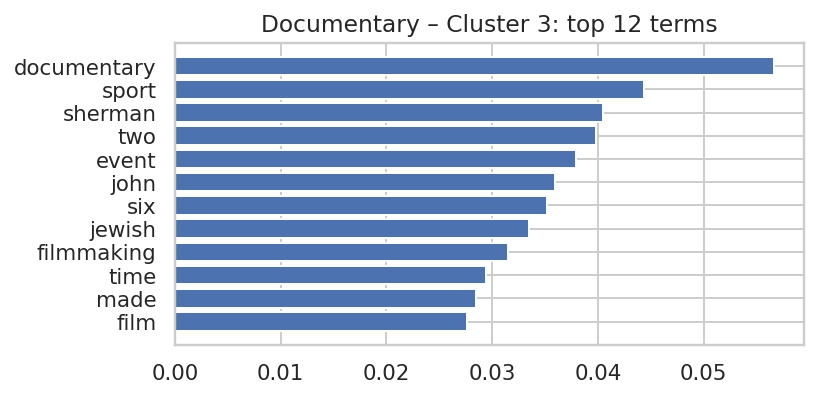

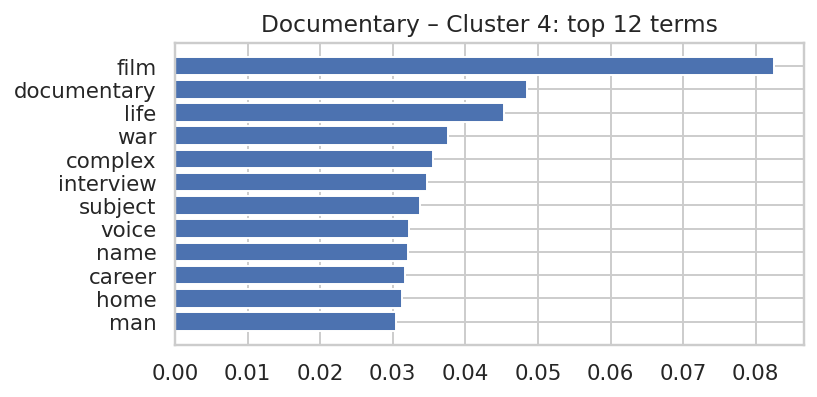

Cluster sizes: {0: 39, 1: 45, 2: 49, 3: 32, 4: 35}
Cluster 0: life, way, city, human, world, site, child, story, year, official, yet, emotional
Cluster 1: one, america, family, community, story, film, year, filmmaker, state, official, money, first
Cluster 2: artist, rock, film, music, life, history, lou, one, year, art, story, group
Cluster 3: documentary, sport, sherman, two, event, john, six, jewish, filmmaking, time, made, film
Cluster 4: film, documentary, life, war, complex, interview, subject, voice, name, career, home, man

=== SciFi ===


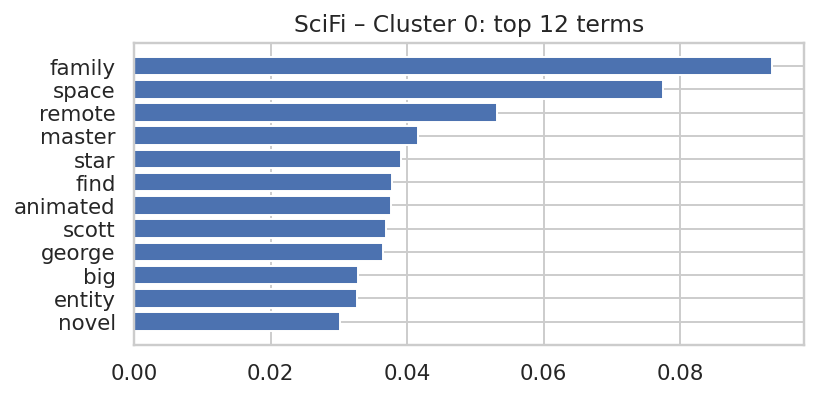

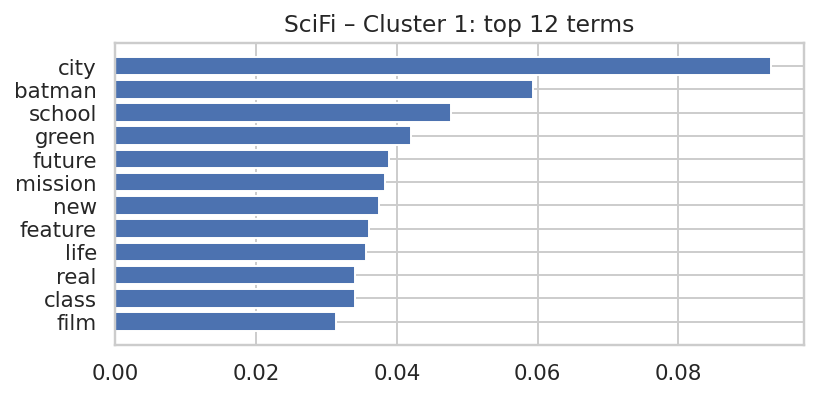

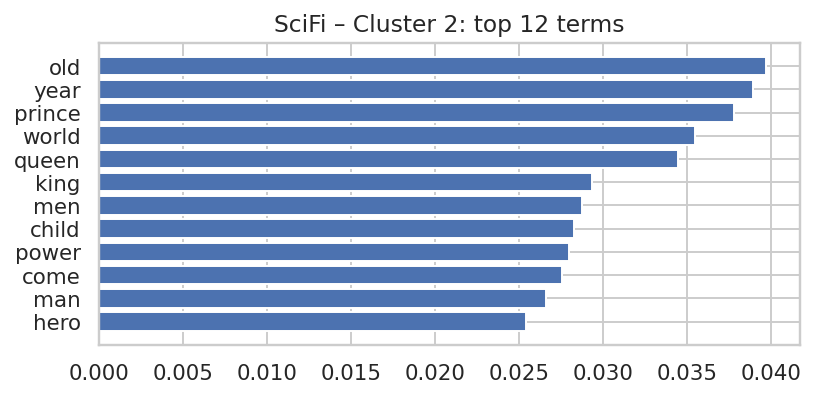

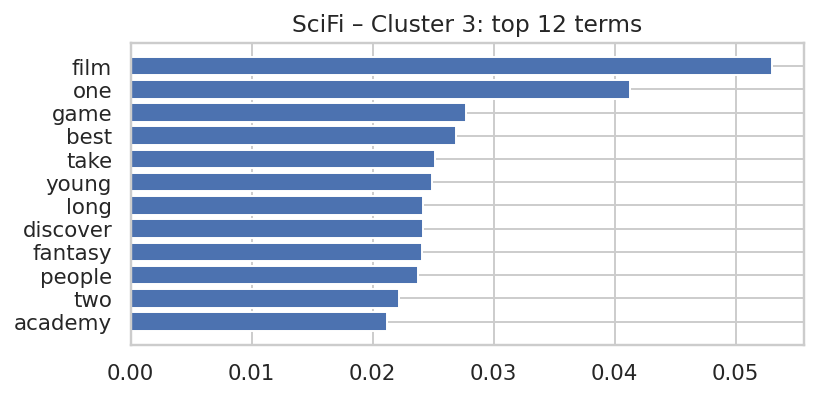

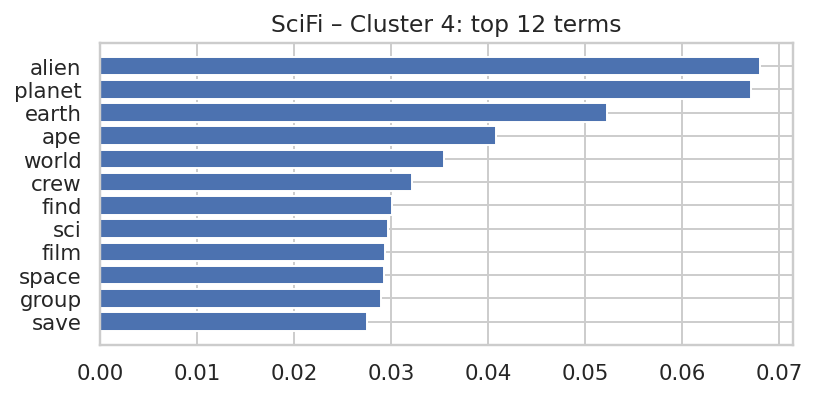

Cluster sizes: {0: 24, 1: 22, 2: 53, 3: 57, 4: 44}
Cluster 0: family, space, remote, master, star, find, animated, scott, george, big, entity, novel
Cluster 1: city, batman, school, green, future, mission, new, feature, life, real, class, film
Cluster 2: old, year, prince, world, queen, king, men, child, power, come, man, hero
Cluster 3: film, one, game, best, take, young, long, discover, fantasy, people, two, academy
Cluster 4: alien, planet, earth, ape, world, crew, find, sci, film, space, group, save

=== Romance ===


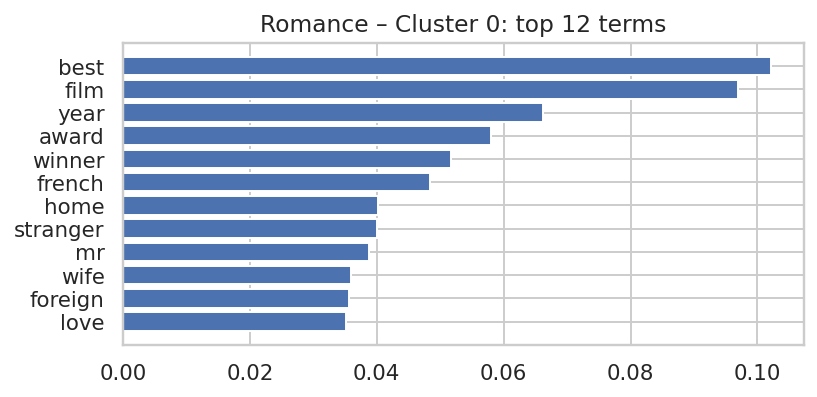

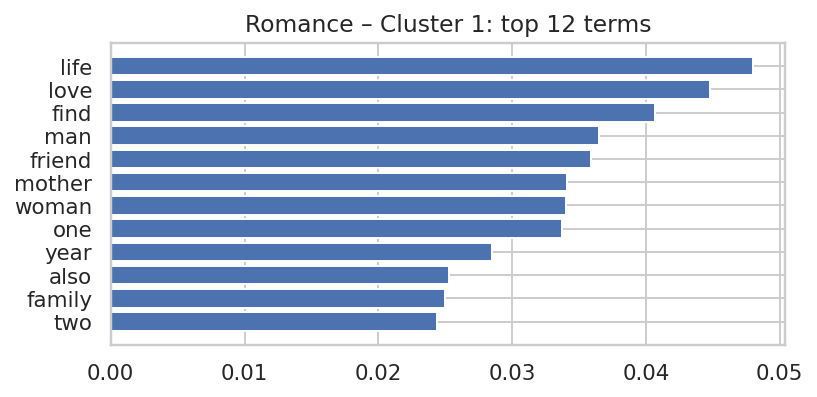

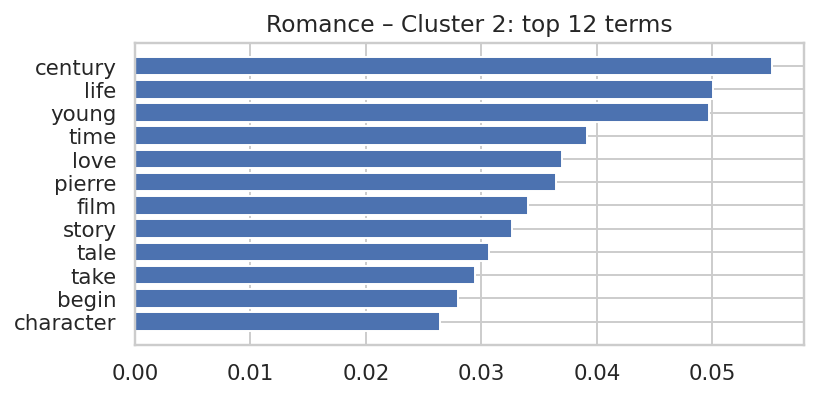

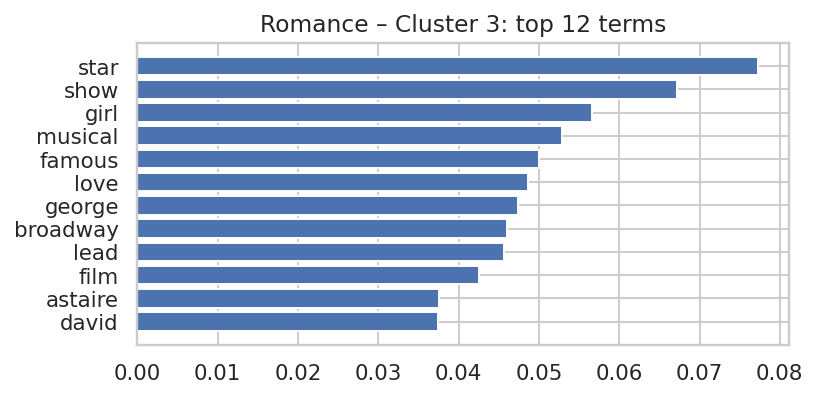

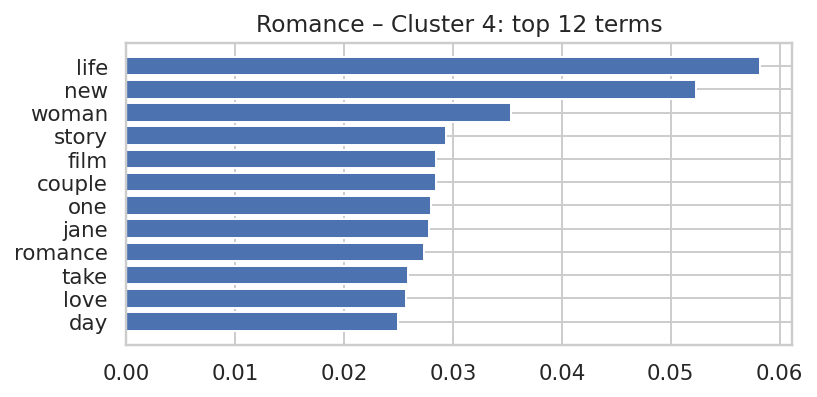

Cluster sizes: {0: 20, 1: 66, 2: 34, 3: 21, 4: 59}
Cluster 0: best, film, year, award, winner, french, home, stranger, mr, wife, foreign, love
Cluster 1: life, love, find, man, friend, mother, woman, one, year, also, family, two
Cluster 2: century, life, young, time, love, pierre, film, story, tale, take, begin, character
Cluster 3: star, show, girl, musical, famous, love, george, broadway, lead, film, astaire, david
Cluster 4: life, new, woman, story, film, couple, one, jane, romance, take, love, day

=== Kids&Family ===


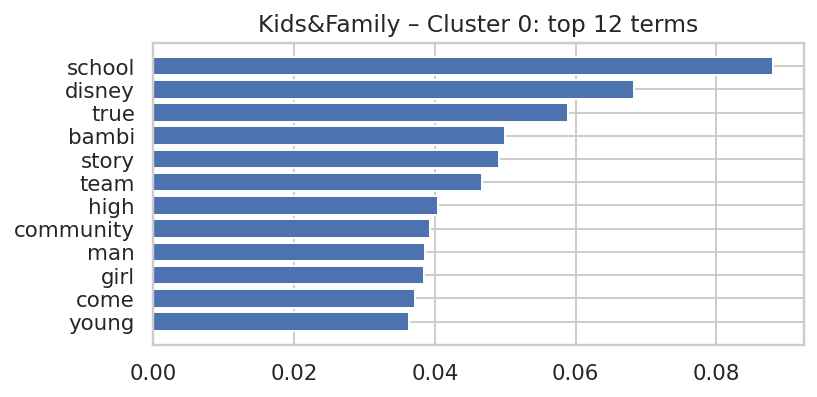

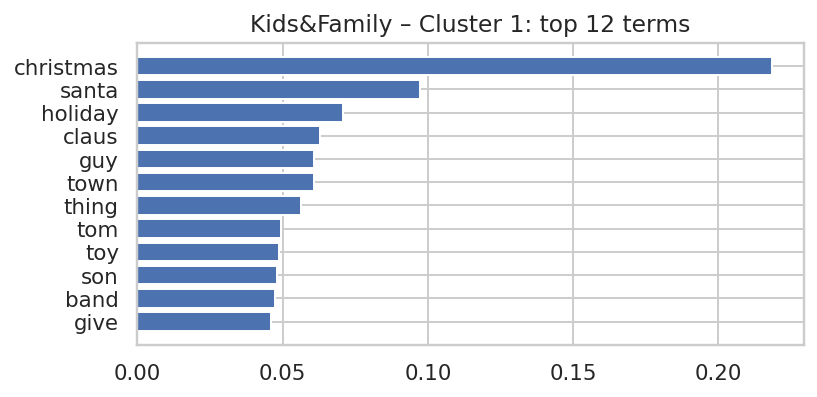

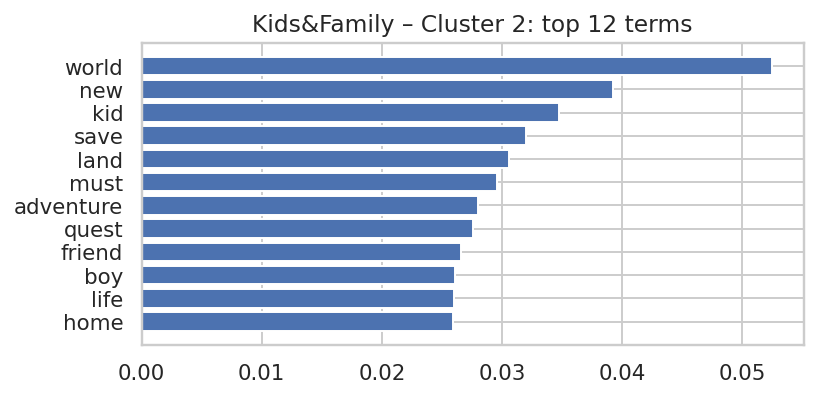

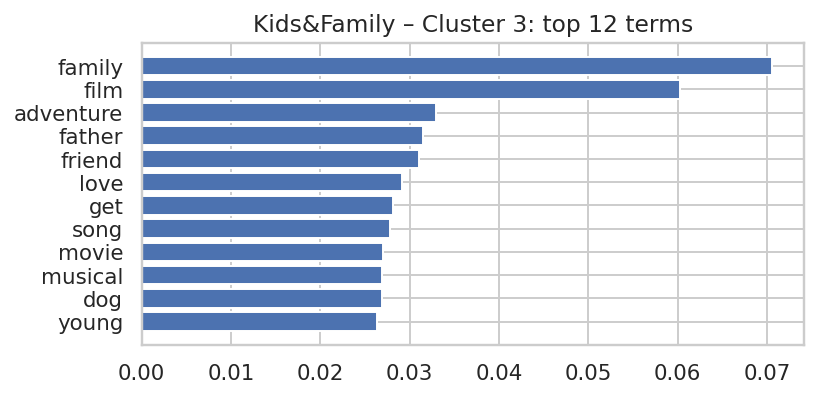

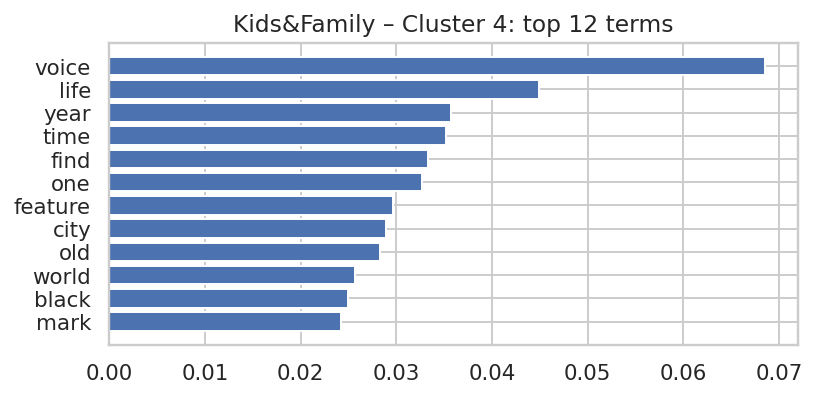

Cluster sizes: {0: 28, 1: 14, 2: 47, 3: 57, 4: 53}
Cluster 0: school, disney, true, bambi, story, team, high, community, man, girl, come, young
Cluster 1: christmas, santa, holiday, claus, guy, town, thing, tom, toy, son, band, give
Cluster 2: world, new, kid, save, land, must, adventure, quest, friend, boy, life, home
Cluster 3: family, film, adventure, father, friend, love, get, song, movie, musical, dog, young
Cluster 4: voice, life, year, time, find, one, feature, city, old, world, black, mark


In [ ]:
### TASK 3 - QUESTION 5

RNG = 42

def cluster_one_genre(sub_df, genre_name, k=5, min_df=3, max_df=0.85, svd_dim=120, topn=12, plot=False):
    print(f"\n=== {genre_name} ===")
    # 1) TF-IDF on preprocessed tokens
    tfidf = TfidfVectorizer(lowercase=False, tokenizer=str.split, preprocessor=None,
                            min_df=min_df, max_df=max_df, ngram_range=(1,1))
    Xtf = tfidf.fit_transform(sub_df["Parsed_str"])
    feats = np.array(tfidf.get_feature_names_out())

    # 2) (Optional) LSA for denoising & speed
    if Xtf.shape[1] > svd_dim:
        svd = TruncatedSVD(n_components=svd_dim, random_state=RNG)
        Xred = svd.fit_transform(Xtf)
    else:
        Xred = Xtf

    # 3) KMeans
    km = KMeans(n_clusters=k, random_state=RNG, n_init=20)
    labels = km.fit_predict(Xred)

    # 4) Top terms per cluster: use mean TF-IDF of original space for docs in each cluster
    tops = {}
    for c in range(k):
        idxs = np.where(labels == c)[0]
        if len(idxs) == 0:
            tops[c] = []
            continue
        mean_vec = np.asarray(Xtf[idxs].mean(axis=0)).ravel()
        top_ids = mean_vec.argsort()[::-1][:topn]
        tops[c] = [(feats[i], float(mean_vec[i])) for i in top_ids]

        if plot:
            terms_c = [feats[i] for i in top_ids][::-1]
            vals_c  = [mean_vec[i] for i in top_ids][::-1]
            plt.figure(figsize=(6,3))
            plt.barh(terms_c, vals_c); plt.title(f"{genre_name} – Cluster {c}: top {topn} terms")
            plt.tight_layout(); plt.show()

    # 5) Size per cluster
    sizes = pd.Series(labels).value_counts().sort_index().rename("count")
    print("Cluster sizes:", sizes.to_dict())

    # Pretty print top-12 terms
    for c in range(k):
        toks = [t for t,_ in tops[c]]
        print(f"Cluster {c}: " + ", ".join(toks))

    return {"labels": labels, "tops": tops, "sizes": sizes, "features": feats, "tfidf": tfidf}

# Run for all 4 genres
models = []
for g, sub in zip(genres_order, sub_data):
    models.append(cluster_one_genre(sub, g, k=5, min_df=3, max_df=0.85, svd_dim=120, topn=12, plot=True))


In [ ]:
### TASK 3 - QUESTION 6

def suggest_label(top_terms):
    # crude heuristic: join top 3–4 tokens with slashes
    words = [t for t,_ in top_terms][:4]
    return "/".join(words)

cluster_names = {}
for (g, sub), m in zip(zip(genres_order, sub_data), models):
    names_g = {}
    print(f"\n== Suggested names for {g} ==")
    for c in range(5):
        label = suggest_label(m["tops"][c])
        names_g[c] = label
        print(f"Cluster {c}: {label}")
    cluster_names[g] = names_g

# How to write the rationale in your report (template)
print("""
Method & rationale to name clusters:
- For each genre, we fitted TF-IDF + (optional) LSA + KMeans (k=5).
- For each cluster, we computed the mean TF-IDF vector across its documents and extracted the top-12 weighted terms.
- A sub-category name is assigned by summarising the dominant concepts appearing in the top terms (e.g., 'space/planet/alien' → 'Space Exploration & Alien Encounters').
- We also verified the name by reading 2–3 representative titles/descriptions from the cluster.
""")



== Suggested names for Documentary ==
Cluster 0: life/way/city/human
Cluster 1: one/america/family/community
Cluster 2: artist/rock/film/music
Cluster 3: documentary/sport/sherman/two
Cluster 4: film/documentary/life/war

== Suggested names for SciFi ==
Cluster 0: family/space/remote/master
Cluster 1: city/batman/school/green
Cluster 2: old/year/prince/world
Cluster 3: film/one/game/best
Cluster 4: alien/planet/earth/ape

== Suggested names for Romance ==
Cluster 0: best/film/year/award
Cluster 1: life/love/find/man
Cluster 2: century/life/young/time
Cluster 3: star/show/girl/musical
Cluster 4: life/new/woman/story

== Suggested names for Kids&Family ==
Cluster 0: school/disney/true/bambi
Cluster 1: christmas/santa/holiday/claus
Cluster 2: world/new/kid/save
Cluster 3: family/film/adventure/father
Cluster 4: voice/life/year/time

Method & rationale to name clusters:
- For each genre, we fitted TF-IDF + (optional) LSA + KMeans (k=5).
- For each cluster, we computed the mean TF-IDF vect

In [ ]:
### TASK 4 - QUESTION 1

# --- Setup
!pip -q install pandas numpy matplotlib seaborn scikit-learn

import re, math, numpy as np, pandas as pd
import matplotlib.pyplot as plt, seaborn as sns
from datetime import datetime, timezone, timedelta
sns.set(style="whitegrid", context="notebook")
plt.rcParams["figure.dpi"] = 140

# --- Path (EDIT THIS)
DATASET4_PATH = "/content/drive/MyDrive/CAB_2/Dataset4_Weblog.txt"

# --- Apache/Nginx Combined Log Format regex (robust, '-')
LOG_PATTERN = re.compile(
    r'(?P<ip>\S+)\s'                              # IP
    r'(?P<ident>\S+)\s'                           # remote logname
    r'(?P<userid>\S+)\s'                          # user id
    r'\[(?P<time>[^\]]+)\]\s'                     # [day/mon/year:hh:mm:ss zone]
    r'"(?P<request>[^"]*)"\s'                     # "METHOD PATH PROTOCOL"
    r'(?P<status>\S+)\s'                          # status
    r'(?P<size>\S+)\s'                            # response size
    r'"(?P<referrer>[^"]*)"\s'                    # "referrer"
    r'"(?P<ua>[^"]*)"'                            # "user-agent"
)

def parse_line(line: str):
    m = LOG_PATTERN.match(line.strip())
    if not m:
        return None
    d = m.groupdict()
    # time
    try:
        ts = datetime.strptime(d["time"], "%d/%b/%Y:%H:%M:%S %z")
    except Exception:
        return None
    # request split
    method, path, protocol = "", "", ""
    if d["request"]:
        parts = d["request"].split()
        if len(parts) >= 1: method   = parts[0]
        if len(parts) >= 2: path     = parts[1]
        if len(parts) >= 3: protocol = parts[2]
    # status/size
    status = None if d["status"] == "-" else int(d["status"])
    size   = 0 if d["size"] in ("-", "") else int(d["size"])
    return {
        "ip": d["ip"],
        "remote_log": None if d["ident"] == "-" else d["ident"],
        "user_id": None if d["userid"] == "-" else d["userid"],
        "timestamp": ts,
        "method": method,
        "path": path,
        "protocol": protocol,
        "status": status,
        "size": size,
        "referrer": None if d["referrer"] in ("-", "") else d["referrer"],
        "user_agent": None if d["ua"] in ("-", "") else d["ua"],
        "raw": line.strip()
    }

# --- Parse file
rows = []
with open(DATASET4_PATH, "r", encoding="utf-8", errors="ignore") as f:
    for ln in f:
        rec = parse_line(ln)
        if rec: rows.append(rec)

logs = pd.DataFrame(rows)
print("Parsed shape:", logs.shape)
display(logs.head())


Parsed shape: (15000, 12)


,ip,remote_log,user_id,timestamp,method,path,protocol,status,size,referrer,user_agent,raw
0,54.36.149.41,None,None,2019-01-22 03:56:14+03:30,GET,/filter/27|13%20%D9%85%DA%AF%D8%A7%D9%BE%DB%8C...,HTTP/1.1,200,30577,None,Mozilla/5.0 (compatible; AhrefsBot/6.1; +http:...,54.36.149.41 - - [22/Jan/2019:03:56:14 +0330] ...
1,31.56.96.51,None,None,2019-01-22 03:56:16+03:30,GET,/image/60844/productModel/200x200,HTTP/1.1,200,5667,https://www.zanbil.ir/m/filter/b113,Mozilla/5.0 (Linux; Android 6.0; ALE-L21 Build...,"31.56.96.51 - - [22/Jan/2019:03:56:16 +0330] ""..."
2,31.56.96.51,None,None,2019-01-22 03:56:16+03:30,GET,/image/61474/productModel/200x200,HTTP/1.1,200,5379,https://www.zanbil.ir/m/filter/b113,Mozilla/5.0 (Linux; Android 6.0; ALE-L21 Build...,"31.56.96.51 - - [22/Jan/2019:03:56:16 +0330] ""..."
3,40.77.167.129,None,None,2019-01-22 03:56:17+03:30,GET,/image/14925/productModel/100x100,HTTP/1.1,200,1696,None,Mozilla/5.0 (compatible; bingbot/2.0; +http://...,40.77.167.129 - - [22/Jan/2019:03:56:17 +0330]...
4,91.99.72.15,None,None,2019-01-22 03:56:17+03:30,GET,/product/31893/62100/%D8%B3%D8%B4%D9%88%D8%A7%...,HTTP/1.1,200,41483,None,Mozilla/5.0 (Windows NT 6.2; Win64; x64; rv:16...,"91.99.72.15 - - [22/Jan/2019:03:56:17 +0330] ""..."


In [ ]:
### TASK 4 - QUESTION 2


# --- Remove static media (graphics/audio/video);
STATIC_PAT = re.compile(r"\.(png|jpe?g|gif|svg|ico|bmp|webp|tiff|mp3|wav|ogg|m4a|flac|mp4|mov|avi|webm)$", re.I)
n_before = len(logs)
logs = logs[~logs["path"].fillna("").str.contains(STATIC_PAT)].copy()
removed_rows = n_before - len(logs)
print(f"Removed static rows: {removed_rows}  | Remaining: {len(logs)}")

# --- Retain features for team version
use_cols = ["ip","timestamp","method","path","status","size","referrer","user_agent"]
logs = logs[use_cols].dropna(subset=["ip","timestamp"]).sort_values(["ip","timestamp"]).reset_index(drop=True)

# --- Sessionise with 30-min inactivity; key = IP + session_start timestamp
INACT_MIN = 30
logs["prev_ts"] = logs.groupby("ip")["timestamp"].shift(1)
gap = (logs["timestamp"] - logs["prev_ts"]).dt.total_seconds().fillna(10**9)
new_sess = (gap > INACT_MIN*60).astype(int)
logs["session_no"] = logs.groupby("ip")["ip"].transform(lambda x: np.arange(len(x)))  # just placeholder
logs["session_id"] = (new_sess.groupby(logs["ip"]).cumsum()
                      .astype(int))
# session start time per group
sess_start = logs.groupby(["ip","session_id"])["timestamp"].transform("min")
logs["session_key"] = logs["ip"] + "_" + sess_start.dt.strftime("%Y%m%d%H%M%S")

# --- check
print("Unique sessions:", logs["session_key"].nunique())
display(logs.head())


Removed static rows: 1344  | Remaining: 13656
Unique sessions: 841


,ip,timestamp,method,path,status,size,referrer,user_agent,prev_ts,session_no,session_id,session_key
0,104.156.210.196,2019-01-22 04:20:05+03:30,GET,/image/32768?name=24xs450-33.jpg&wh=200x200,200,7669,None,Dalvik/2.1.0 (Linux; U; Android 8.0.0; SM-A720...,NaT,0,1,104.156.210.196_20190122042005
1,104.194.24.33,2019-01-22 03:57:07+03:30,GET,/amp-helper-frame.html?appId=a624a1c1-0c93-466...,200,133,https://www-zanbil-ir.cdn.ampproject.org/v/s/w...,Mozilla/5.0 (Linux; Android 8.0.0; SM-G955F) A...,NaT,0,1,104.194.24.33_20190122035707
2,104.194.24.54,2019-01-22 04:24:09+03:30,GET,/image/33888?name=model-b2048u-1-.jpg&wh=200x200,200,3975,None,Dalvik/2.1.0 (Linux; U; Android 6.0.1; SM-G900...,NaT,0,1,104.194.24.54_20190122042409
3,104.194.24.54,2019-01-22 04:26:43+03:30,GET,/image/11947?name=11947-1-fw.jpg&wh=200x200,200,4167,None,Dalvik/2.1.0 (Linux; U; Android 6.0.1; SM-G900...,2019-01-22 04:24:09+03:30,1,1,104.194.24.54_20190122042409
4,104.194.25.207,2019-01-22 04:06:47+03:30,GET,/image/33888?name=model-b2048u-1-.jpg&wh=200x200,200,3975,None,Dalvik/2.1.0 (Linux; U; Android 5.0.2; P01V Bu...,NaT,0,1,104.194.25.207_20190122040647


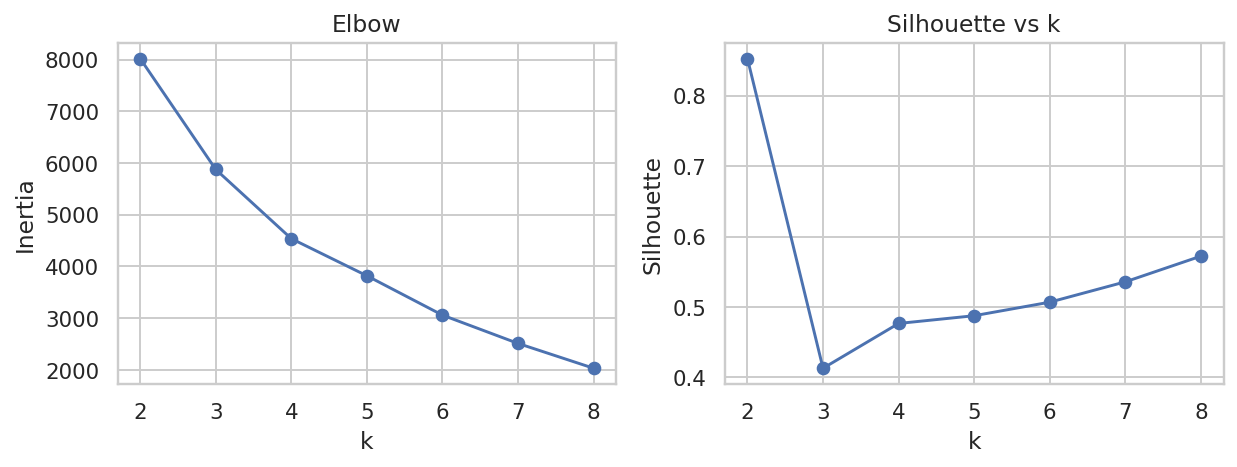

Chosen k (max silhouette) = 2


,session_key,hits,ip,start,end,bytes_total,unique_paths,n_2xx,n_3xx,n_4xx,n_5xx,ref_ext,ref_none,bot_ratio,duration_s,share_2xx,share_3xx,share_4xx,share_5xx,hour,dow,cluster
0,104.156.210.196_20190122042005,1,104.156.210.196,2019-01-22 04:20:05+03:30,2019-01-22 04:20:05+03:30,7669,1,1,0,0,0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,4,1,0
1,104.194.24.33_20190122035707,1,104.194.24.33,2019-01-22 03:57:07+03:30,2019-01-22 03:57:07+03:30,133,1,1,0,0,0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,3,1,0
2,104.194.24.54_20190122042409,2,104.194.24.54,2019-01-22 04:24:09+03:30,2019-01-22 04:26:43+03:30,8142,2,2,0,0,0,0.0,1.0,0.0,154.0,1.0,0.0,0.0,0.0,4,1,0
3,104.194.25.207_20190122040647,3,104.194.25.207,2019-01-22 04:06:47+03:30,2019-01-22 04:06:55+03:30,12519,3,3,0,0,0,0.0,1.0,0.0,8.0,1.0,0.0,0.0,0.0,4,1,0
4,104.244.77.52_20190122044246,1,104.244.77.52,2019-01-22 04:42:46+03:30,2019-01-22 04:42:46+03:30,133,1,1,0,0,0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,4,1,0


In [ ]:
### TASK 4 - QUESTION 3

from urllib.parse import urlparse
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# --- Helper: referrer & UA categories
def ref_type(url):
    if not isinstance(url, str) or url == "-": return "none"
    try:
        host = urlparse(url).netloc
        return "internal" if (host == "" or host.endswith("yourdomain.com")) else "external"
    except:
        return "unknown"

def ua_type(ua):
    if not isinstance(ua, str): return "unknown"
    ua_l = ua.lower()
    if re.search(r"(bot|spider|crawl|slurp)", ua_l): return "bot"
    if "mobile" in ua_l: return "mobile"
    return "browser"

logs["ref_type"] = logs["referrer"].apply(ref_type)
logs["ua_type"]  = logs["user_agent"].apply(ua_type)

# --- Aggregate to sessions
def pct(series, cond):
    s = series.fillna(-1)
    return (s==cond).mean()

g = logs.groupby("session_key", as_index=False)
sessions = pd.DataFrame({
    "session_key": g.size()["session_key"],
    "hits": g.size()["size"],
})
# Add aggregations
agg = g.agg(
    ip=("ip","first"),
    start=("timestamp","min"),
    end=("timestamp","max"),
    bytes_total=("size","sum"),
    unique_paths=("path", lambda s: s.nunique()),
    n_2xx=("status", lambda s: (s//100==2).sum()),
    n_3xx=("status", lambda s: (s//100==3).sum()),
    n_4xx=("status", lambda s: (s//100==4).sum()),
    n_5xx=("status", lambda s: (s//100==5).sum()),
    ref_ext=("ref_type", lambda s: (s=="external").mean()),
    ref_none=("ref_type", lambda s: (s=="none").mean()),
    bot_ratio=("ua_type", lambda s: (s=="bot").mean()),
)
sessions = sessions.merge(agg, on="session_key", how="left")
sessions["duration_s"] = (sessions["end"] - sessions["start"]).dt.total_seconds().clip(lower=0)
# shares
tot = (sessions[["n_2xx","n_3xx","n_4xx","n_5xx"]].sum(axis=1)).replace(0,1)
for c in ["n_2xx","n_3xx","n_4xx","n_5xx"]:
    sessions[c.replace("n_","share_")] = (sessions[c]/tot).fillna(0)

# Time features
sessions["hour"] = sessions["start"].dt.hour
sessions["dow"]  = sessions["start"].dt.dayofweek

feat_cols = ["hits","unique_paths","duration_s","bytes_total",
             "share_2xx","share_3xx","share_4xx","share_5xx",
             "ref_ext","ref_none","bot_ratio","hour","dow"]
X = sessions[feat_cols].fillna(0).copy()

# --- Scale
scaler = StandardScaler()
Xs = scaler.fit_transform(X)

# --- Choose k via elbow & silhouette
ks = range(2,9)
inert, sils = [], []
for k in ks:
    km = KMeans(n_clusters=k, random_state=42, n_init=20)
    lab = km.fit_predict(Xs)
    inert.append(km.inertia_)
    sils.append(silhouette_score(Xs, lab))

fig, ax = plt.subplots(1,2, figsize=(9,3.5))
ax[0].plot(list(ks), inert, marker="o"); ax[0].set_xlabel("k"); ax[0].set_ylabel("Inertia"); ax[0].set_title("Elbow")
ax[1].plot(list(ks), sils, marker="o"); ax[1].set_xlabel("k"); ax[1].set_ylabel("Silhouette"); ax[1].set_title("Silhouette vs k")
plt.tight_layout(); plt.show()

best_k = list(ks)[int(np.argmax(sils))]
print(f"Chosen k (max silhouette) = {best_k}")
km = KMeans(n_clusters=best_k, random_state=42, n_init=20)
sessions["cluster"] = km.fit_predict(Xs)
sessions.head()


hits            unique_paths            duration_s          \
            mean  min   max         mean  min   max       mean     min   
cluster                                                                  
0          10.78    1   474         9.52    1   388     364.04     0.0   
1        1157.50  598  2053      1101.50  595  1845    3041.75  1388.0   

                 bytes_total                     share_2xx             \
            max         mean       min       max      mean   min  max   
cluster                                                                 
0        3596.0    197801.68         0  16507247      0.86  0.00  1.0   
1        3595.0  33068877.00  20332854  46659428      0.92  0.72  1.0   

        share_3xx            share_4xx            share_5xx           ref_ext  \
             mean  min   max      mean  min   max      mean  min  max    mean   
cluster                                                                         
0            0.12  0.0  1.00      0.01  0.0  1.00       0.0  0.0  0.0    0.26   
1            0.06  0.0  0.21      0.02  0.0  0.07       0.0  0.0  0.0    0.00   

                  ref_none           bot_ratio            hour          dow  \
         min  max     mean  min  max      mean  min  max  mean min max mean   
cluster                                                                       
0        0.0  1.0     0.74  0.0  1.0      0.51  0.0  1.0  3.87   3   4  1.0   
1        0.0  0.0     1.00  1.0  1.0      0.75  0.0  1.0  3.00   3   3  1.0   

                 
        min max  
cluster          
0         1   1  
1         1   1

Counts per cluster:
 cluster
0    837
1      4
Name: count, dtype: int64


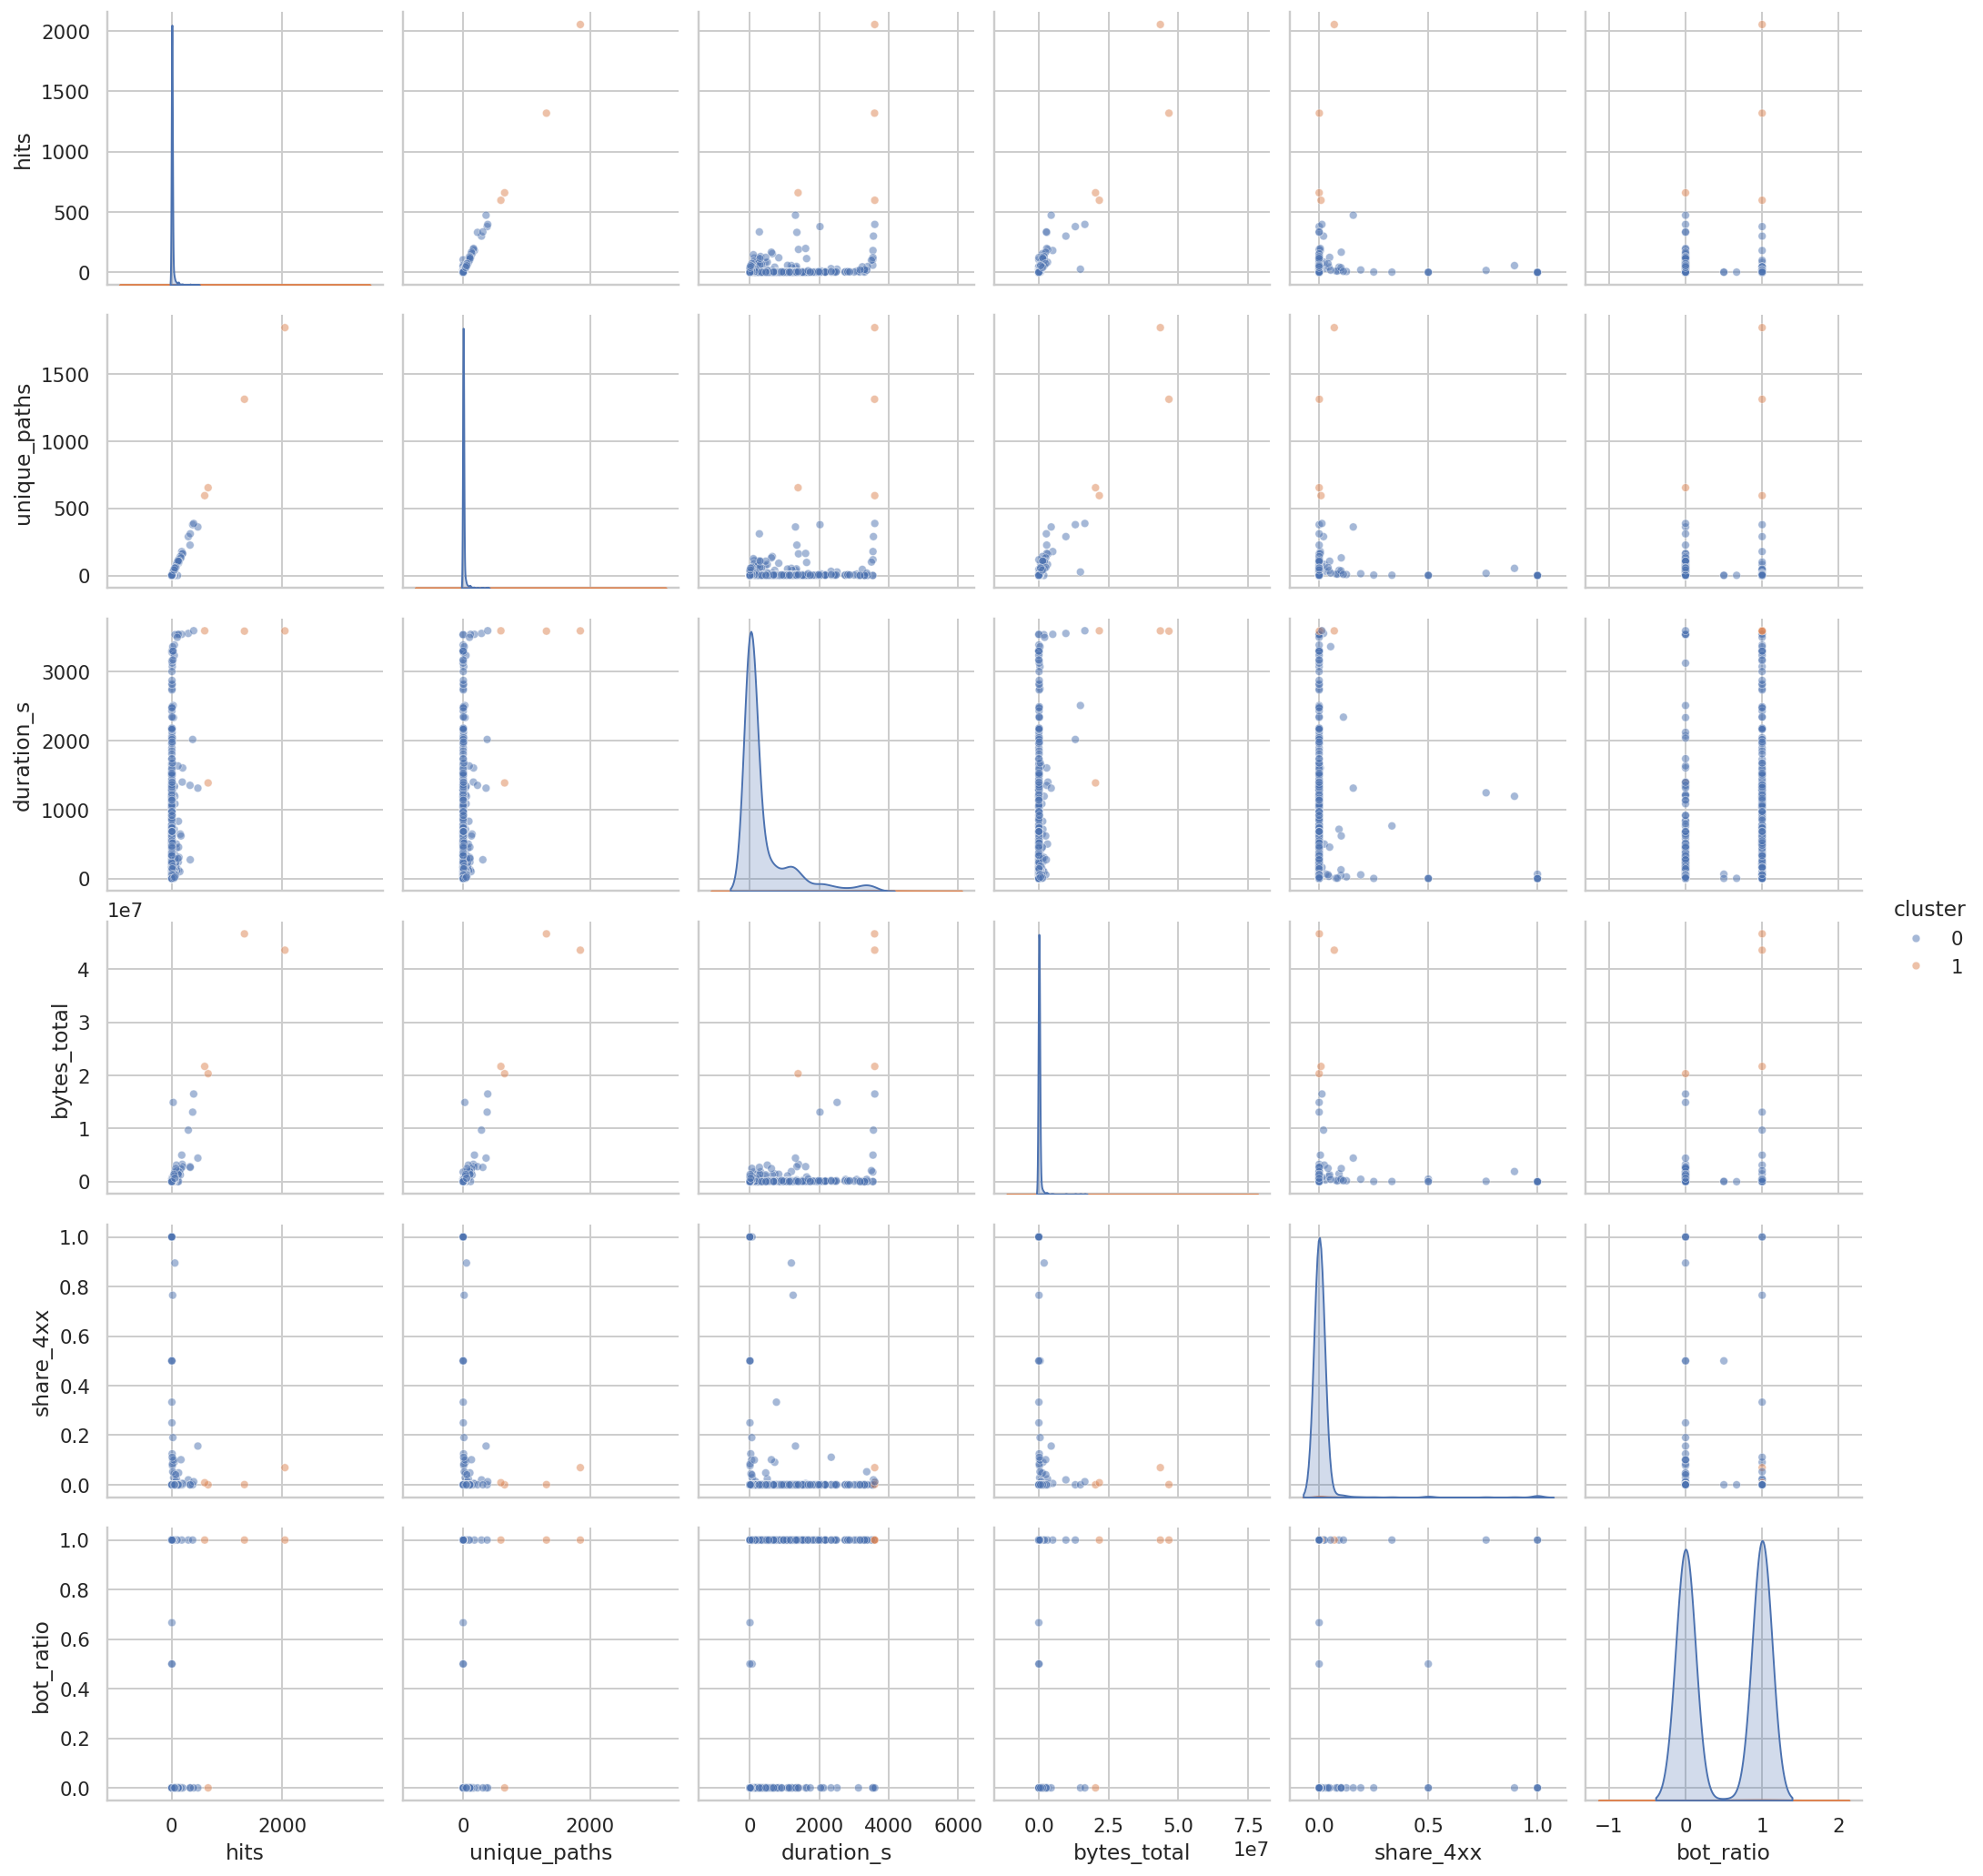

Top 404 paths:
 path
/amp_preconnect_polyfill_404_or_other_error_expected._Do_not_worry_about_it?1548117540000    19
/amp_preconnect_polyfill_404_or_other_error_expected._Do_not_worry_about_it?1548117360000    15
/amp_preconnect_polyfill_404_or_other_error_expected._Do_not_worry_about_it?1548117180000    15
/amp_preconnect_polyfill_404_or_other_error_expected._Do_not_worry_about_it?1548117720000     9
/amp_preconnect_polyfill_404_or_other_error_expected._Do_not_worry_about_it?1548117900000     8
/amp_preconnect_polyfill_404_or_other_error_expected._Do_not_worry_about_it?1548119160000     6
/amp_preconnect_polyfill_404_or_other_error_expected._Do_not_worry_about_it?1548119700000     6
/amp_preconnect_polyfill_404_or_other_error_expected._Do_not_worry_about_it?1548119520000     5
/amp_preconnect_polyfill_404_or_other_error_expected._Do_not_worry_about_it?1548118260000     5
/amp_preconnect_polyfill_404_or_other_error_expected._Do_not_worry_about_it?1548117000000     5
dtype: int64

User-

,bot_ratio
cluster,
0,0.509
1,0.750


In [ ]:
### TASK 4 - QUESTION 4


# --- Profile table
prof = (sessions.groupby("cluster")[feat_cols]
        .agg(["mean","min","max"]).round(2))
display(prof)

# --- Cluster sizes
size = sessions["cluster"].value_counts().sort_index()
print("Counts per cluster:\n", size)

# --- Quick visual: pairwise distribution for key features
key_feats = ["hits","unique_paths","duration_s","bytes_total","share_4xx","bot_ratio"]
sns.pairplot(pd.concat([sessions[key_feats], sessions["cluster"]], axis=1),
             hue="cluster", plot_kws={"alpha":0.5, "s":20})
plt.show()

# --- A few concrete signals to help naming
top404 = (logs[logs["status"]==404].groupby("path")
          .size().sort_values(ascending=False).head(10))
print("Top 404 paths:\n", top404)

ua_by_cluster = logs.merge(
    sessions[["session_key","cluster"]],
    left_on="session_key",
    right_on="session_key",
    how="left"
)
print("\nUser-agent types per cluster:")
display(sessions.groupby("cluster")["bot_ratio"].mean().round(3))


In [ ]:
### TASK 4 - QUESTION 5